
---

# Tutorial: Quantum Phase Classifier

This tutorial covers one of the most representative applications of Quantum Machine Learning (QML): **Quantum Phase Classification**. We will learn how quantum states change according to the parameter variations of a physical system, and build a **Quantum Neural Network (QNN)** that predicts which phase an unknown state belongs to.

## 1. What is a Quantum Phase?

Water that we encounter in daily life has three **phases** depending on temperature: **ice (solid)**, **water (liquid)**, and **steam (gas)**. Similarly, quantum materials at extremely low temperatures near absolute zero ($0K$) also have various **quantum phases** with completely different physical properties depending on external conditions (magnetic field, pressure, interaction strength, etc.).

### ⚛️ Quantum Phase Transition
A quantum system is described by an energy operator called the **Hamiltonian ($H$)**. When the parameters of this Hamiltonian (e.g., interaction coupling constants $J_1, J_2$) change, there are points where the most stable state of the system, the **ground state**, changes abruptly. This is called a **quantum phase transition**.

* **Input:** Ground state $|\psi(J_1, J_2)\rangle$ corresponding to Hamiltonian parameters $(J_1, J_2)$
* **Output:** **Phase label** that the state belongs to (e.g., Ferromagnetic, Antiferromagnetic, Topological Insulator, etc.)

In traditional physics, phases were distinguished by finding specific physical quantities called **order parameters** manually. However, quantum state classifiers allow machine learning models to **learn patterns (features) that distinguish phases from data on their own**.

---

## 2. Why is Quantum Phase Classification Important?

Quantum phase classification goes beyond mere physical curiosity and is important in quantum computing and materials science for the following key reasons.

### 🚀 1. Discovery of New Matter
Not all quantum phases can be explained by simple order parameters. In particular, exotic states such as **topological insulators** or **quantum spin liquids** have **global entanglement** patterns that cannot be distinguished by local measurements. QML can contribute to discovering new physical properties by finding these complex patterns that are difficult for humans to intuitively identify.

### 📉 2. Overcoming Exponential Complexity
As the size of a quantum system (number of qubits) increases, the amount of information needed to completely describe its state grows **exponentially ($2^N$)**.
* **Traditional approach (Tomography):** Requires an exponential number of measurements to know the quantum state.
* **QML approach:** Models like QNN can efficiently extract essential phase information with only a **small number of measurements and parameters** without needing to know the complete information.

### 🧠 3. Acting as the 'Eyes' of Quantum Computers (Quantum Readout)
Even if future quantum computers perform useful material simulations, it is difficult to convert the resulting complex quantum states into a form we can understand (e.g., "this material is a conductor"). Quantum state classifiers serve as **interpreters that translate complex data inside quantum computers into meaningful results for users**.

---

Now, let's build a QNN that accurately classifies quantum phases with small amounts of data using the **Generalized Cluster Hamiltonian** model.

---

## 3. Dataset Generation & Quantum State Configuration

The dataset used in this tutorial consists of ground states from the **1D Generalized Cluster Model**. This model is one of the standard models used to study **phase transitions** in quantum many-body systems.

### ⚛️ Hamiltonian Definition

We deal with a system consisting of 8 qubits ($N=8$), assuming Periodic Boundary Conditions. The Hamiltonian $H$ that describes the energy of the system is as follows:

$$
H = \sum_{j=1}^{N} \left( Z_j - J_1 X_j X_{j+1} - J_2 X_{j-1} Z_j X_{j+1} \right)
$$

Here, $X_j, Z_j$ are Pauli operators acting on the $j$-th qubit. The properties of this system are determined by two coupling constants **$J_1$** and **$J_2$**.

* **$J_1$ (Ising Interaction):** The strength of interaction between adjacent qubits. When this term dominates, the system has **Ferromagnetic (FM)** or **Antiferromagnetic (AFM)** order.
* **$J_2$ (Cluster Interaction):** The strength of interaction among three qubits. When this term dominates, the system has a **Cluster Phase (SPT)**.

### 🗺️ Phase Diagram

For randomly sampled $(J_1, J_2)$ pairs, we diagonalize the Hamiltonian matrix to calculate the **ground state** $|\psi(J_1, J_2)\rangle$ with the lowest energy.

These states are divided into 4 regions in the $(J_1, J_2)$ space:

1.  **Cluster Phase (Haldane/SSH):** Top and bottom regions
2.  **Trivial Phase:** Central region
3.  **Ferromagnetic (FM) Phase:** Right region
4.  **Anti-Ferromagnetic (AFM) Phase:** Left region

### ⚠️ Important: Very Small Training Set

One of the key objectives of this tutorial is to demonstrate **how efficiently a QNN can learn with limited data**.

* **Train Set:** We use only **20 samples**. (About 4-5 per phase)
* **Test Set:** We use **800 samples** to verify generalization performance.

While typical deep learning models (DNN) require thousands or tens of thousands of data points, QNN is designed to capture the symmetry and structural features of quantum states well, so it can **accurately reconstruct the entire phase diagram with only a minimal amount of data**.

Now let's generate the dataset for training and visualize its distribution.
from src.plots import plot_phase_distribution



In [1]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9247/preliminary_data.zip
!unzip preliminary_data.zip

--2025-12-20 17:40:26--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9247/preliminary_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6442016 (6.1M) [application/zip]
Saving to: ‘preliminary_data.zip.1’

preliminary_data.zi 100%[===================>]   6.14M  --.-KB/s    in 0.02s   

2025-12-20 17:40:26 (256 MB/s) - ‘preliminary_data.zip.1’ saved [6442016/6442016]

Archive:  preliminary_data.zip
replace __MACOSX/._preliminary_data? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._preliminary_data  
  inflating: preliminary_data/grid_X.npy  
  inflating: __MACOSX/preliminary_data/._grid_X.npy  
  inflating: preliminary_data/grid_params.npy  
  inflating: __MACOSX/preliminary_data/._grid_params.npy  
  inflating:

In [2]:
!pip install pennylane

In [3]:
import numpy as np
from scipy.sparse import csr_matrix, kron, identity
from scipy.sparse.linalg import eigsh
import tqdm

# =============================================================================
# 1. PAULI MATRICES DEFINITION
# =============================================================================
# In quantum computing, Pauli matrices are fundamental 2x2 matrices that describe
# single-qubit operations. They are the building blocks for constructing Hamiltonians.
#
# - I (Identity): Does nothing, leaves the qubit unchanged
# - X (Pauli-X): Flips the qubit state (like a NOT gate), |0⟩ ↔ |1⟩
# - Z (Pauli-Z): Adds a phase flip, |0⟩ → |0⟩, |1⟩ → -|1⟩
#
# We use sparse matrices for efficiency since most entries are zero.
# For an 8-qubit system, matrices are 256x256 (2^8), but mostly sparse.
# =============================================================================

I = identity(2, format='csr')  # 2x2 Identity matrix (sparse format)
X = csr_matrix([[0, 1], [1, 0]])  # Pauli-X matrix (bit flip)
Z = csr_matrix([[1, 0], [0, -1]])  # Pauli-Z matrix (phase flip)


def get_pauli_term(n_qubits, op, site):
    """
    Creates a full n-qubit operator with a Pauli operator acting on a specific qubit.

    In a multi-qubit system, we need to specify which qubit an operator acts on.
    This is done using the tensor product (⊗): I ⊗ I ⊗ X ⊗ I ⊗ I ...
    where X is placed at the target qubit position and I elsewhere.

    Example for 4 qubits, X on qubit 2:
        Result = I ⊗ I ⊗ X ⊗ I (tensor product of identity matrices with X at position 2)

    Args:
        n_qubits (int): Total number of qubits in the system.
        op (scipy.sparse): The Pauli operator to apply (X, Z, etc.).
        site (int): The qubit index (0 to n_qubits-1) where the operator acts.

    Returns:
        scipy.sparse: A 2^n × 2^n sparse matrix representing the full operator.
    """
    # Start building the tensor product from qubit 0
    if site == 0:
        term = op  # If target is qubit 0, start with the operator
    else:
        term = I   # Otherwise, start with identity

    # Build the rest of the tensor product for qubits 1 to n-1
    for i in range(1, n_qubits):
        if i == site:
            term = kron(term, op, format='csr')  # Place operator at target site
        else:
            term = kron(term, I, format='csr')   # Place identity elsewhere
    return term


def build_hamiltonian(n_qubits, J1, J2):
    """
    Constructs the Generalized Cluster Hamiltonian for given coupling parameters.

    The Hamiltonian describes the energy of the quantum system and determines
    its behavior. Different values of J1 and J2 lead to different quantum phases.

    Mathematical form:
        H = Σⱼ [ Zⱼ - J₁·Xⱼ·Xⱼ₊₁ - J₂·Xⱼ₋₁·Zⱼ·Xⱼ₊₁ ]

    Where:
        - Zⱼ: Local magnetic field term on qubit j
        - J₁·Xⱼ·Xⱼ₊₁: Nearest-neighbor interaction (Ising-like coupling)
        - J₂·Xⱼ₋₁·Zⱼ·Xⱼ₊₁: Three-body cluster interaction

    The competition between these terms creates different quantum phases:
        - Large |J₁|: Ferromagnetic or Antiferromagnetic order
        - Large |J₂|: Cluster/Topological phase
        - Balanced: Trivial phase

    Args:
        n_qubits (int): Number of qubits in the chain.
        J1 (float): Coupling strength for nearest-neighbor XX interaction.
        J2 (float): Coupling strength for three-body XZX interaction.

    Returns:
        scipy.sparse: The Hamiltonian matrix (2^n × 2^n sparse matrix).
    """
    # Initialize empty Hamiltonian matrix
    H = csr_matrix((2**n_qubits, 2**n_qubits))

    # Sum over all qubits in the chain
    for j in range(n_qubits):
        # Periodic Boundary Conditions (PBC): The chain forms a ring
        # Qubit after the last connects back to the first
        idx_prev = (j - 1) % n_qubits  # Previous qubit (wraps around)
        idx_curr = j                    # Current qubit
        idx_next = (j + 1) % n_qubits  # Next qubit (wraps around)

        # Term 1: Zⱼ (local field term)
        # This represents a magnetic field in the Z direction on qubit j
        term_z = get_pauli_term(n_qubits, Z, idx_curr)

        # Term 2: -J₁ · Xⱼ · Xⱼ₊₁ (two-body interaction)
        # This couples neighboring qubits through their X components
        op_x_curr = get_pauli_term(n_qubits, X, idx_curr)
        op_x_next = get_pauli_term(n_qubits, X, idx_next)
        term_xx = -J1 * (op_x_curr @ op_x_next)  # Matrix multiplication

        # Term 3: -J₂ · Xⱼ₋₁ · Zⱼ · Xⱼ₊₁ (three-body cluster interaction)
        # This creates entanglement between three consecutive qubits
        op_x_prev = get_pauli_term(n_qubits, X, idx_prev)
        op_z_curr = get_pauli_term(n_qubits, Z, idx_curr)
        term_xzx = -J2 * (op_x_prev @ op_z_curr @ op_x_next)

        # Add all terms to the Hamiltonian
        H += term_z + term_xx + term_xzx

    return H


def get_ground_state(H):
    """
    Finds the ground state (lowest energy state) of the Hamiltonian.

    The ground state is the quantum state with the minimum energy.
    It contains all the information about the system's quantum phase.

    We use sparse eigenvalue solver (eigsh) which is efficient for large,
    sparse matrices. The 'SA' option finds the Smallest Algebraic eigenvalue.

    Args:
        H (scipy.sparse): The Hamiltonian matrix.

    Returns:
        numpy.ndarray: The ground state vector (normalized, complex-valued).
    """
    # k=1: find only 1 eigenvalue, which='SA': smallest algebraic (lowest energy)
    eigval, eigvec = eigsh(H, k=1, which='SA')
    return eigvec[:, 0]  # Return the eigenvector (ground state)


# =============================================================================
# 2. PHASE LABELING LOGIC
# =============================================================================
# The quantum phase depends on the coupling parameters (J1, J2).
# Different regions in the (J1, J2) parameter space correspond to different phases.
# This function determines which phase a given (J1, J2) point belongs to.
#
# Note: This is a simplified labeling for the tutorial. The actual phase
# boundaries in the hackathon problem are UNKNOWN and must be learned!
# =============================================================================

def get_phase_label(J1, J2):
    """
    Determines the phase label based on J1 and J2 parameters.

    The (J1, J2) parameter space is divided into 4 regions (phases).
    Phase boundaries are determined by theoretical analysis of the Hamiltonian.

    Args:
        J1 (float): Nearest-neighbor coupling strength.
        J2 (float): Three-body coupling strength.

    Returns:
        int: Phase label (0, 1, 2, or 3).
    """
    # Phase boundaries are defined by linear equations in the (J1, J2) space
    if J2 < -J1 - 1 and J2 > J1 - 1:
        label = 2
    elif J2 > -J1 - 1 and J2 < J1 - 1:
        label = 1
    elif J2 > J1 - 1 and J2 > -J1 - 1 and J2 < 1:
        label = 3
    else:
        label = 0

    return label


# =============================================================================
# 3. DATASET GENERATION
# =============================================================================
# This section generates training and test data by:
# 1. Sampling random (J1, J2) parameter values
# 2. Building the Hamiltonian for each parameter set
# 3. Computing the ground state
# 4. Labeling the phase
#
# The result is a dataset of (ground_state, label) pairs for training.
# =============================================================================

def generate_dataset(n_qubits, n_samples, j_range=(-4.0, 4.0), uniform=True):
    """
    Generates a dataset of quantum ground states and their phase labels.

    For each sample:
    1. Randomly sample coupling parameters (J1, J2)
    2. Construct the Hamiltonian H(J1, J2)
    3. Compute the ground state |ψ(J1, J2)⟩
    4. Determine the phase label

    Args:
        n_qubits (int): Number of qubits in the system.
        n_samples (int): Total number of samples to generate.
        j_range (tuple): Range for random sampling of J1, J2 values.
        uniform (bool): If True, sample uniformly. If False, balance classes.

    Returns:
        tuple: (dataset, labels, params)
            - dataset: Array of ground state vectors, shape (n_samples, 2^n_qubits)
            - labels: Array of phase labels, shape (n_samples,)
            - params: Array of (J1, J2) parameters, shape (n_samples, 2)
    """
    dataset = []
    labels = []
    params = []

    print(f"Generating {n_samples} samples for {n_qubits}-qubit system...")

    # Generate samples in batches (5 batches for progress tracking)
    for i in range(5):
        for _ in tqdm.tqdm(range(n_samples // 5)):
            continue_sampling = True

            # Keep sampling until we get a valid sample
            while continue_sampling:
                # Random sampling of coupling parameters
                J1 = np.random.uniform(j_range[0], j_range[1])
                J2 = np.random.uniform(j_range[0], j_range[1])

                if uniform:
                    # Accept any sample for uniform distribution
                    continue_sampling = False
                else:
                    # For balanced classes, only accept if it matches target phase
                    if get_phase_label(J1, J2) == i % 4:
                        if i != 4:
                            continue_sampling = False
                        else:
                            if J2 < -1:
                                continue_sampling = False

            # Build Hamiltonian and compute ground state
            H = build_hamiltonian(n_qubits, J1, J2)
            ground_state = get_ground_state(H)
            label = get_phase_label(J1, J2)

            # Store the results
            dataset.append(ground_state)
            labels.append(label)
            params.append((J1, J2))

    return np.array(dataset), np.array(labels), np.array(params)


# =============================================================================
# 4. LOAD DATA
# =============================================================================
# For the tutorial, we use pre-generated data to save computation time.
# The ground state calculation can be slow for large systems.
#
# You can uncomment the generate_dataset() calls below to create your own data.
# =============================================================================

# System configuration
N_QUBITS = 8      # Number of qubits (state vector size = 2^8 = 256)
N_TRAIN = 20      # Number of training samples (intentionally small!)
N_TEST = 2000     # Number of test samples for evaluation

# Load pre-generated data from files
# Each file contains:
#   - train_X / test_X: Ground state vectors (complex-valued, shape: n_samples × 256)
#   - train_y / test_y: Phase labels (integers 0-3)
#   - train_params / test_params: (J1, J2) parameter values used to generate each state
train_X, train_y, train_params = (
    np.load('preliminary_data/train_X.npy', allow_pickle=True),
    np.load('preliminary_data/train_y.npy', allow_pickle=True),
    np.load('preliminary_data/train_params.npy', allow_pickle=True)
)
test_X, test_y, test_params = (
    np.load('preliminary_data/test_X.npy', allow_pickle=True),
    np.load('preliminary_data/test_y.npy', allow_pickle=True),
    np.load('preliminary_data/test_params.npy', allow_pickle=True)
)

# Alternatively, you can generate your own data (uncomment below):
train_X, train_y, train_params = generate_dataset(n_qubits=8, n_samples=20, uniform=False)
#test_X, test_y, test_params = generate_dataset(n_qubits=8, n_samples=2000)

# Display dataset information
print(f"Train set shape: {train_X.shape}")  # Expected: (20, 256) for 8 qubits
print(f"Test set shape: {test_X.shape}")    # Expected: (2000, 256) for 8 qubits

Generating 20 samples for 8-qubit system...


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Train set shape: (20, 256)
Test set shape: (2000, 256)


In [4]:
# Load data for a decision boundary
grid_X = np.load('preliminary_data/grid_X.npy')
grid_params = np.load('preliminary_data/grid_params.npy')
grid_Y = np.load('preliminary_data/grid_y.npy')

---

## Understanding Phase Boundaries

### 🌊 What Happens at Phase Boundaries?

Imagine water at exactly 0°C - it can be either ice or liquid, and tiny changes in temperature cause dramatic transformations. **Quantum phase boundaries** work similarly, but instead of temperature, they depend on the Hamiltonian parameters $(J_1, J_2)$.

### 🔬 How Quantum States Change Across Phases

When a quantum system crosses a phase boundary, its ground state $|\psi\rangle$ undergoes **qualitative changes**:

| Property | Deep Inside a Phase | Near Phase Boundary |
|----------|---------------------|---------------------|
| **State Structure** | Stable, well-defined pattern | Mixture of competing patterns |
| **Entanglement** | Characteristic of that phase | Transitional, complex |
| **Classification** | Easy to identify | Ambiguous, harder to classify |

### 📐 Physical Meaning of Phase Boundaries

The phase boundaries in our system are determined by the **competition between different interaction terms**:

$$
H = \sum_{j} \left( \underbrace{Z_j}_{\text{Local field}} - \underbrace{J_1 X_j X_{j+1}}_{\text{Nearest-neighbor}} - \underbrace{J_2 X_{j-1} Z_j X_{j+1}}_{\text{Cluster interaction}} \right)
$$

- **When $|J_1|$ dominates:** The system prefers aligned or anti-aligned neighboring spins → **Ferromagnetic/Antiferromagnetic phases**
- **When $|J_2|$ dominates:** The system develops complex three-body correlations → **Cluster/Topological phase**
- **At the boundary:** Neither term dominates, creating **quantum superposition** of both tendencies

### 🎯 Why Boundaries Matter for Classification

1. **Easy regions (far from boundaries):**
   - States have distinctive features
   - High classification accuracy expected
   - The quantum state "looks" clearly like its phase

2. **Hard regions (near boundaries):**
   - States blend characteristics of multiple phases
   - Classification becomes challenging
   - Small parameter changes can flip the phase label

### 💡 Intuition for Your Model

Think of it like recognizing colors:
- **Deep red** and **deep blue** are easy to distinguish
- **Purple** (mix of red and blue) is ambiguous and harder to classify

Similarly, quantum states near phase boundaries exhibit **mixed characteristics**, making them the most challenging samples for your classifier. A good QNN should:
- Correctly classify states deep within each phase (easier)
- Handle boundary states gracefully (harder, but important for high accuracy)

Understanding this helps you interpret your model's errors - most mistakes typically occur near phase boundaries, which is physically expected!

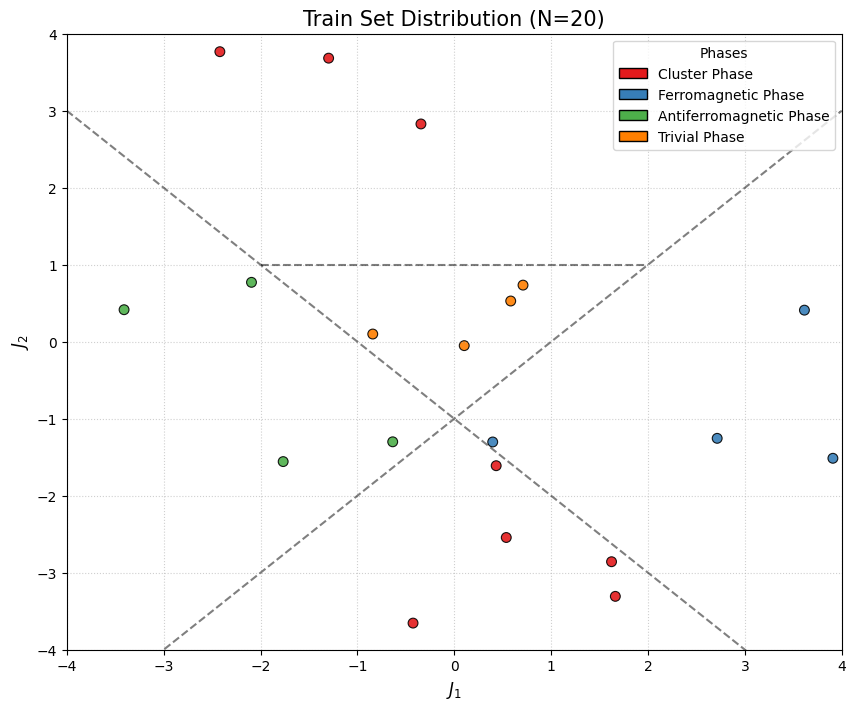

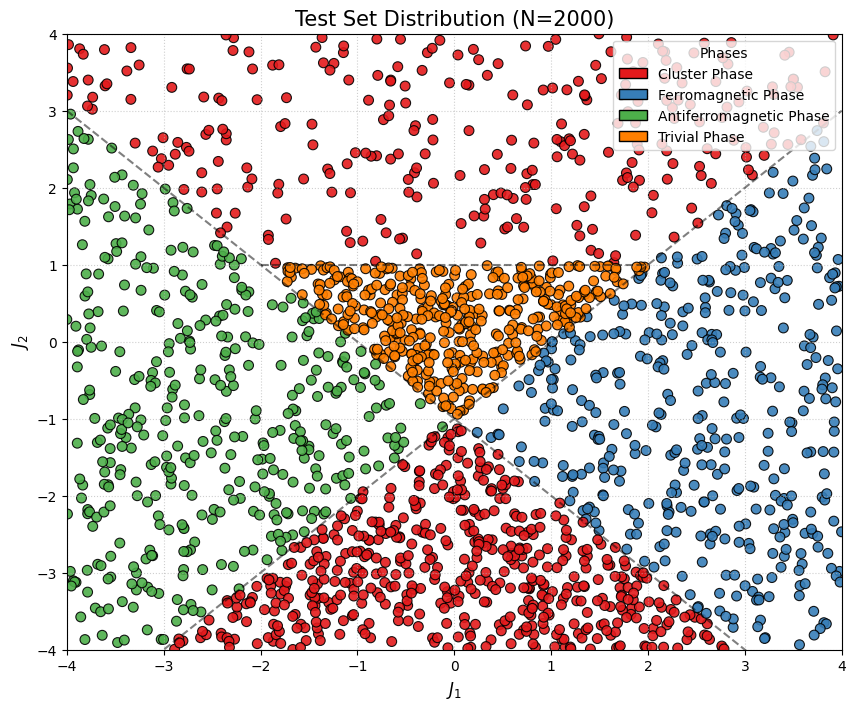

In [5]:
import matplotlib.pyplot as plt
import numpy as np


names = ['Cluster Phase', 'Ferromagnetic Phase', 'Antiferromagnetic Phase', 'Trivial Phase']
# ==========================================
# 2. Visualization Logic (Modified)
# ==========================================
def draw_boundaries(ax, j1_min, j1_max):
    """Draws the theoretical phase boundaries."""
    x_range = np.linspace(j1_min, j1_max, 200)
    x_range_2 = np.linspace(-2, 2, 200)
    # Boundary lines: J2 = 1, J2 = 2*J1 - 1, J2 = -2*J1 - 1
    ax.plot(x_range, -x_range - 1, 'k--', linewidth=1, alpha=0.3) # Left diagonal
    ax.plot(x_range, x_range - 1, 'k--', linewidth=1, alpha=0.3)  # Right diagonal
    ax.plot(x_range_2, np.ones_like(x_range_2), 'k--', linewidth=1, alpha=0.3)  # Horizontal line at J2=1


def plot_phase_distribution(params, labels, title="Phase Distribution"):
    """
    J1, J2 파라미터와 라벨을 받아 산점도로 시각화합니다.
    """
    J1_vals = params[:, 0]
    J2_vals = params[:, 1]
    plt.figure(figsize=(10, 8))

    # Use distinct, high-contrast colors for better visibility
    phase_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00']  # Red, Blue, Green, Orange
    colors = [phase_colors[int(l)] for l in labels]

    scatter = plt.scatter(J1_vals, J2_vals, c=colors, s=50, alpha=0.9, edgecolors='black', linewidth=0.8)

    # Create custom legend
    unique_labels = np.unique(labels)
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=phase_colors[int(l)], edgecolor='black', label=names[int(l)]) for l in unique_labels]
    plt.legend(handles=handles, title="Phases", loc="upper right")

    x_range = np.linspace(-4,4, 100)
    x_range_2 = np.linspace(-2,2, 100)
    plt.plot(x_range, -x_range - 1, 'k--', alpha=0.5, label='Boundary 1') # J2 = -J1 - 1
    plt.plot(x_range, x_range - 1, 'k--', alpha=0.5, label='Boundary 2')  # J2 = J1 - 1
    plt.plot(x_range_2, np.ones_like(x_range_2), 'k--', alpha=0.5, label='Boundary 3')  # J2 = 1
    plt.title(title, fontsize=15)
    plt.xlabel(r"$J_1$", fontsize=12)
    plt.ylabel(r"$J_2$", fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)


    plt.show()


import torch
from sklearn.neighbors import KNeighborsClassifier

def plot_fast_decision_boundary(model, t_test_X, test_params, resolution=200, title="QCNN Decision Boundary (Fast Visualization)"):
    """
    Test Set의 예측 결과를 바탕으로 배경을 빠르게 채워 시각화합니다.
    Hamiltonian 계산을 다시 하지 않으므로 매우 빠릅니다.
    """

    # 1. Test Set에 대한 QCNN 예측 (Inference)
    # 이미 생성된 데이터를 사용하므로 빠름
    model.eval()
    with torch.no_grad():
        outputs = model(t_test_X)
        pred_test_y = torch.argmax(outputs, dim=1).cpu().numpy()

    # 2. 시각화를 위한 경량 모델(KNN) 학습
    # QCNN이 예측한 결과(pred_test_y)를 정답으로 삼아 배경을 칠합니다.
    # n_neighbors=1로 하면 가장 가까운 점의 색을 그대로 따라가므로 영역이 선명하게 나뉩니다.
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(test_params, pred_test_y)

    # 3. Meshgrid 생성 (배경용)
    j1_range = np.linspace(-4, 4, resolution)
    j2_range = np.linspace(-4, 4, resolution)
    J1_grid, J2_grid = np.meshgrid(j1_range, j2_range)

    # Grid 포인트 준비
    grid_points = np.c_[J1_grid.ravel(), J2_grid.ravel()]

    # 4. KNN으로 배경 예측 (순식간에 완료)
    Z = knn.predict(grid_points)
    Z = Z.reshape(J1_grid.shape)

    # 5. 시각화 (Plotting)
    plt.figure(figsize=(12, 10))

    # 배경: 결정 경계 (pcolormesh 사용)
    # 0~4 (혹은 그 이상) 클래스에 대해 색상 매핑
    plt.pcolormesh(J1_grid, J2_grid, Z, cmap='tab10', alpha=0.3, shading='auto', vmin=0, vmax=9)



    # 테스트 데이터도 작게 찍어서 밀도 확인 (선택 사항, 너무 많으면 주석 처리)
    # plt.scatter(test_params[:, 0], test_params[:, 1], c='k', s=1, alpha=0.1)

    # 범례 추가
    legend_names = {i: names[i] for i in range(4)}
    from matplotlib.patches import Patch
    cmap = plt.get_cmap('tab10')
    handles = [Patch(facecolor=cmap(i), label=legend_names[i]) for i in range(4)]


    plt.legend(handles=handles, loc='upper right', title="Phases")

    draw_boundaries(plt.gca(), -4, 4)

     # 스타일 설정


    plt.title(title, fontsize=18)
    plt.xlabel(r"$J_1 (J_x)$", fontsize=14)
    plt.ylabel(r"$J_2 (J_c)$", fontsize=14)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

    plt.show()





# ==========================================
# 2. Visualization Logic (2 Rows x 3 Cols)
# ==========================================
def plot_full_comparison(train_params, train_true, train_pred,
                         test_params, test_true, test_pred):

    fig, axes = plt.subplots(2, 3, figsize=(24, 16))

    # High-contrast colors for better visibility
    phase_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00']  # Red, Blue, Green, Orange
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(phase_colors)

    # --- Row 1: Train Set ---
    J1_tr, J2_tr = train_params[:, 0], train_params[:, 1]
    mask_tr = (train_pred != train_true)
    train_acc = np.mean(train_pred == train_true)
    test_acc = np.mean(test_pred == test_true)

    # 1-1. Ground Truth
    ax = axes[0, 0]
    train_colors_true = [phase_colors[int(l)] for l in train_true]
    ax.scatter(J1_tr, J2_tr, c=train_colors_true, s=80, edgecolors='k', alpha=0.9, linewidth=0.8)
    draw_boundaries(ax, -4, 4)
    ax.set_title(f"Train: Ground Truth (N={len(train_true)})", fontsize=16, fontweight='bold')
    # Custom legend
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=phase_colors[i], edgecolor='black', label=names[i]) for i in range(4)]
    ax.legend(handles=handles, title="Phases", loc="upper right")

    # 1-2. Prediction
    ax = axes[0, 1]
    train_colors_pred = [phase_colors[int(l)] for l in train_pred]
    ax.scatter(J1_tr, J2_tr, c=train_colors_pred, s=80, edgecolors='k', alpha=0.9, linewidth=0.8)
    ax.legend(handles=handles, title="Phases", loc="upper right")
    draw_boundaries(ax, -4, 4)
    ax.set_title(f"Train: Model Prediction (Acc: {train_acc*100:.1f}%)", fontsize=16, fontweight='bold')

    # 1-3. Misclassified
    ax = axes[0, 2]
    # 맞은 것: 회색 흐리게
    ax.scatter(J1_tr[~mask_tr], J2_tr[~mask_tr], c='gray', s=40, alpha=0.1, label='Correct')
    # 틀린 것: 빨간색 X 강조
    if np.any(mask_tr):
        ax.scatter(J1_tr[mask_tr], J2_tr[mask_tr], c='red', marker='x', s=150, linewidth=2.5, label='Misclassified')
    draw_boundaries(ax, -4, 4)
    ax.set_title("Train: Misclassified Points", fontsize=16, fontweight='bold')
    ax.legend(loc="upper right")

    # --- Row 2: Test Set ---
    J1_te, J2_te = test_params[:, 0], test_params[:, 1]
    mask_te = (test_pred != test_true)

    # 2-1. Ground Truth
    ax = axes[1, 0]
    test_colors_true = [phase_colors[int(l)] for l in test_true]
    ax.scatter(J1_te, J2_te, c=test_colors_true, s=20, alpha=0.7, edgecolors='none')
    draw_boundaries(ax, -4, 4)
    ax.set_title(f"Test: Ground Truth (N={len(test_true)})", fontsize=16)

    # 2-2. Prediction
    ax = axes[1, 1]
    test_colors_pred = [phase_colors[int(l)] for l in test_pred]
    ax.scatter(J1_te, J2_te, c=test_colors_pred, s=20, alpha=0.7, edgecolors='none')
    draw_boundaries(ax, -4, 4)
    ax.set_title(f"Test: Model Prediction (Acc: {test_acc*100:.1f}%)", fontsize=16)

    # 2-3. Misclassified
    ax = axes[1, 2]
    ax.scatter(J1_te[~mask_te], J2_te[~mask_te], c='gray', s=10, alpha=0.05) # Test는 점이 많으니 더 흐리게
    if np.any(mask_te):
        ax.scatter(J1_te[mask_te], J2_te[mask_te], c='red', marker='x', s=40, linewidth=1, label='Error')
    draw_boundaries(ax, -4, 4)
    ax.set_title("Test: Misclassified Points", fontsize=16)
    ax.legend(loc="upper right")

    # 공통 스타일 설정
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlabel(r"$J_1$", fontsize=12)
            ax.set_ylabel(r"$J_2$", fontsize=12)
            ax.set_xlim(-4, 4)
            ax.set_ylim(-4, 4)
            ax.grid(True, linestyle=':', alpha=0.4)

    plt.tight_layout()
    plt.show()
    return train_acc, test_acc


# Visualize distributions
plot_phase_distribution(train_params, train_y, title=f"Train Set Distribution (N={N_TRAIN})")
plot_phase_distribution(test_params, test_y, title=f"Test Set Distribution (N={N_TEST})")

---

## 4. Training with Classical Neural Network

Now let's train a classical neural network model using the prepared **20 Training Samples**.

### 🧠 Model Architecture (Classical NN)
For comparison, we use a simple Fully Connected Neural Network structure.

* **Input Layer:** $2^8 = 256$ (size of quantum state vector)
* **Hidden Layer:** 15 (ReLU activation function)
* **Output Layer:** 4 (probabilities for phase labels 0, 1, 2, 3)

### 🎯 Learning Objective
The purpose of this step is to observe **"the difficulties classical models face when data is scarce"**.
Since the classical neural network has insufficient training data ($20$ samples) compared to the input dimension ($256$), there is a high probability of **overfitting** or poor **generalization** performance on the test set.

Can a classical model properly learn the complex phase boundaries with this limited data? Let's check the results.

In [6]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import torch
# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

# Data Preparation
t_train_X, t_train_y = data_to_tensor(train_X, train_y)
t_test_X, t_test_y = data_to_tensor(test_X, test_y)

BATCH_SIZE = 20
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

n_qubits = 8

# Classical Neural Network Classifier
class ClassicalNN(nn.Module):
    def __init__(self, input_size=2**n_qubits, hidden_size=15, output_size=4):
        super(ClassicalNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = ClassicalNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

epochs = 200
loss_history = []
acc_history = []

for epoch in range(epochs):
    total_loss = 0
    correct = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X.to(device=device, dtype=torch.float32))
        loss = nn.CrossEntropyLoss()(predictions, batch_y.to(device=device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)
        batch_y = batch_y.to(predicted_classes.device)
        correct += (predicted_classes == batch_y).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / len(train_dataset)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(
/tmp/ipython-input-4192252823.py:66: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:309.)
  predictions = model(batch_X.to(device=device, dtype=torch.float32))


Epoch 50 | Loss: 0.0050 | Train Acc: 1.0000
Epoch 100 | Loss: 0.0009 | Train Acc: 1.0000
Epoch 150 | Loss: 0.0005 | Train Acc: 1.0000
Epoch 200 | Loss: 0.0003 | Train Acc: 1.0000


## 5. Analysis of Classical Neural Network Training Results

Let's visually examine the performance of the trained classical neural network model.

### 📊 Key Points to Observe
1.  **Train Set (upper Graph):** Check how well the model fits the training data (20 samples). It will likely show accuracy close to 100%.
2.  **Test Set (under Graph):** Prediction results for data not used in training (800 samples).
    *   **Shape of Boundaries:** Does it properly follow the complex boundary lines of the phase diagram? Or does it appear as simple straight lines or distorted shapes?
    *   **Generalization Performance:** Check if it overfits to the Train Set and shows significantly reduced performance on the Test Set.

Classical neural networks are very powerful when there is sufficient data, but in situations where **data is extremely limited ($N=20$)**, they are likely to **simplify or form distorted decision boundaries** without properly learning the complex quantum phase boundaries.

Now let's check the actual prediction results in graphs.

Running inference...


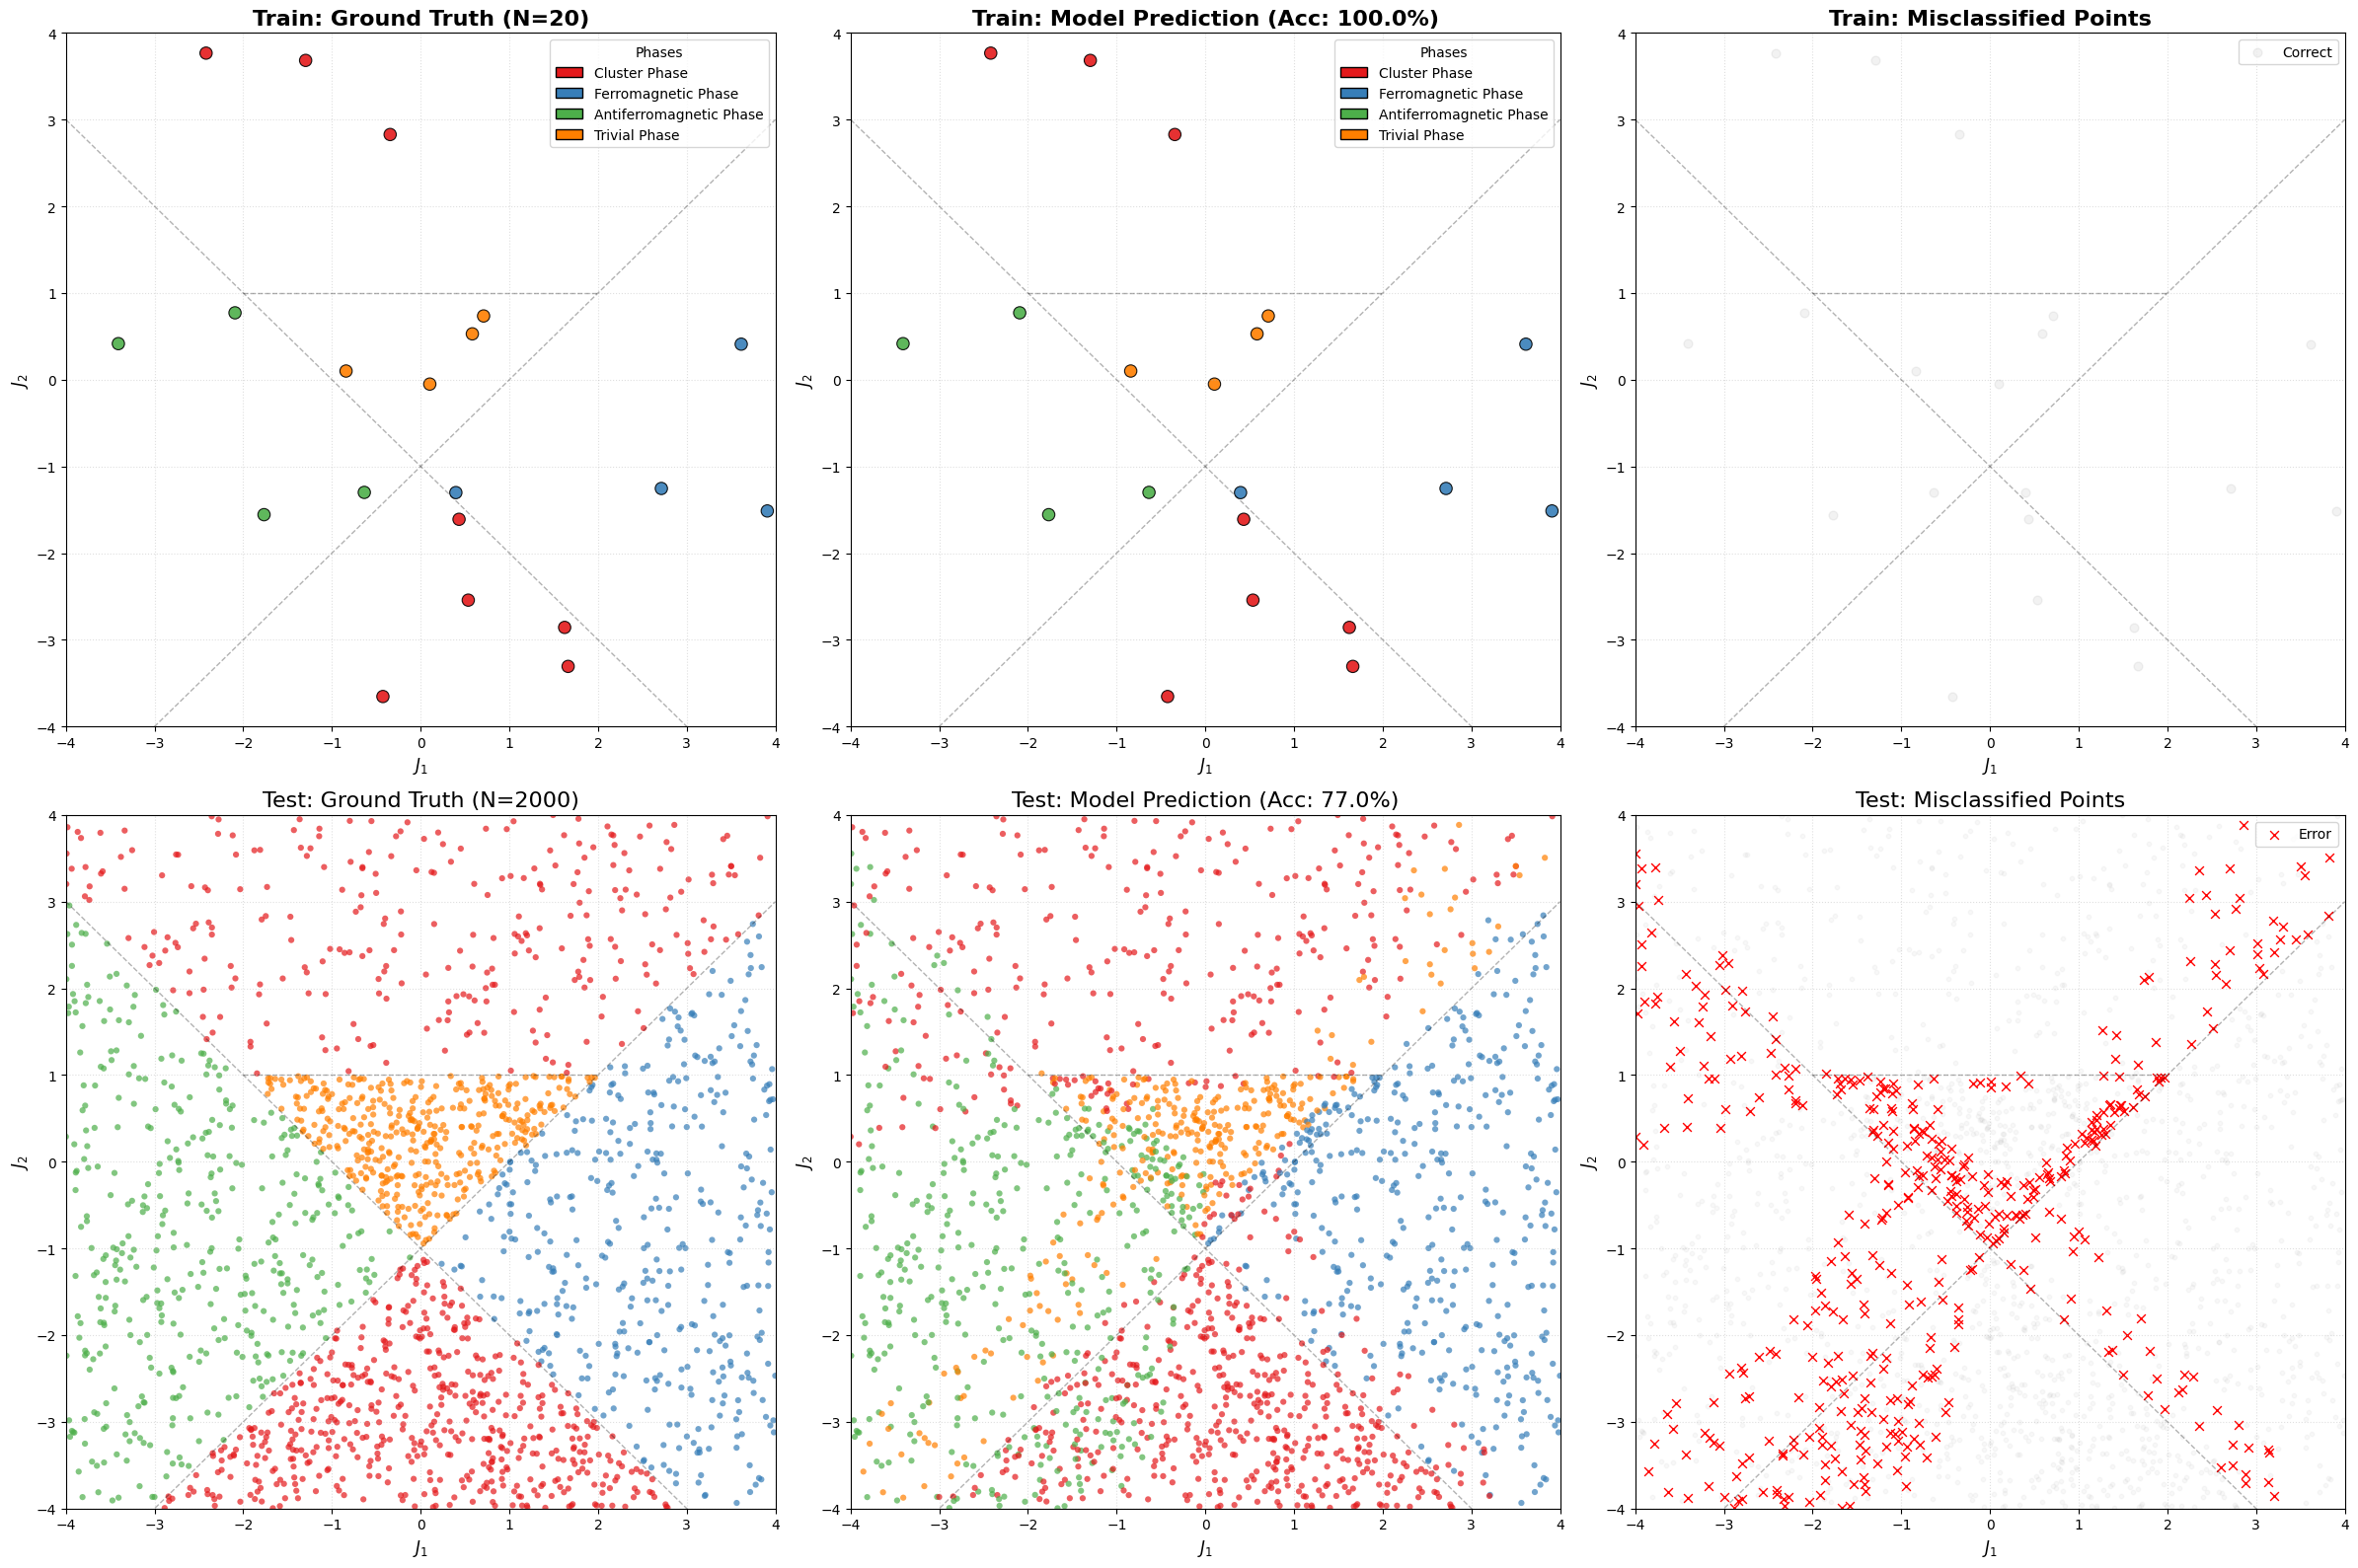

(np.float64(1.0), np.float64(0.77))

In [7]:
print("Running inference...")
# Train Set Prediction
pred_train_y = get_predictions(model, t_train_X.to(device=device, dtype=torch.float32))
true_train_y = t_train_y.numpy()

# Test Set Prediction
pred_test_y = get_predictions(model, t_test_X.to(device=device, dtype=torch.float32))
true_test_y = t_test_y.numpy()

plot_full_comparison(train_params, true_train_y, pred_train_y,
                     test_params, true_test_y, pred_test_y)

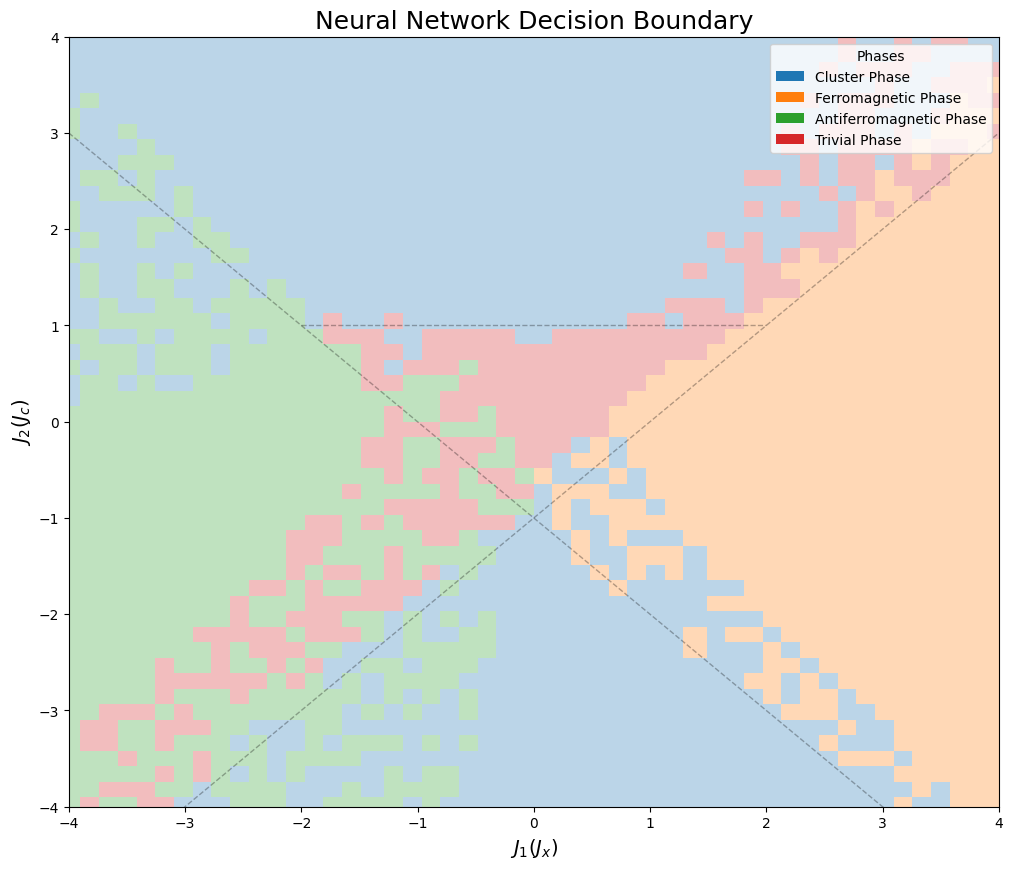

In [8]:
train_y_np = grid_Y.numpy() if torch.is_tensor(grid_Y) else grid_Y

plot_fast_decision_boundary(model, torch.tensor(grid_X).to(device=device, dtype=torch.float32), grid_params, title = 'Neural Network Decision Boundary')

---

## 6. Training with Quantum Neural Network (QNN)

Now let's train a **Quantum Neural Network (QNN)** model using the same **20 Training Samples**.

### ⚛️ Model Architecture (Quantum Circuit)
Here we use the **Linear 2-Qubit Block** structure.
* **Input:** Quantum state $|\psi\rangle$ (8 qubits)
* **Ansatz:** Parameterized Quantum Circuit (PQC) composed of rotation gates (Rot) and CNOT gates
* **Measurement:** Probability measurement of the last qubits

In [9]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# =============================================================================
# QUANTUM NEURAL NETWORK (QNN) SETUP
# =============================================================================
# This section builds a Quantum Neural Network for phase classification.
# Unlike classical neural networks that use matrix multiplications,
# QNNs use quantum gates to transform quantum states.
# =============================================================================

# Number of qubits in our quantum circuit (matches the input state dimension)
n_qubits = 8

# Create a quantum device (simulator) to run our quantum circuits
# "default.qubit" is PennyLane's built-in statevector simulator
# In the future, this could be replaced with actual quantum hardware!
dev = qml.device("default.qubit", wires=n_qubits)


# =============================================================================
# QUANTUM CIRCUIT (ANSATZ) DEFINITION
# =============================================================================
# The "Ansatz" is the parameterized quantum circuit that we will train.
# It consists of:
#   1. Rotation gates (Rot): Single-qubit gates with 3 learnable parameters each
#   2. CNOT gates: Two-qubit entangling gates that create quantum correlations
#
# Structure: [Rotation Layer → CNOT Layer] × (num_layers-1) → Final Rotation Layer
# =============================================================================

def Quantum_classifier(params):
    """
    Parameterized Quantum Circuit (PQC) - The "Ansatz" for our classifier.

    This is the quantum equivalent of a neural network's hidden layers.
    The circuit transforms the input quantum state using learnable parameters.

    Circuit Structure (Linear Entanglement):
    ┌──────────┐     ┌──────────┐
    │ Rot(θ,φ,λ)│─●───│ Rot(θ,φ,λ)│─●───  ...  ─│ Rot(θ,φ,λ)│
    └──────────┘ │   └──────────┘ │             └──────────┘
    ┌──────────┐ X   ┌──────────┐ X
    │ Rot(θ,φ,λ)│─●───│ Rot(θ,φ,λ)│─●───  ...  ─│ Rot(θ,φ,λ)│
    └──────────┘ │   └──────────┘ │             └──────────┘
         ...     X        ...     X                  ...

    Args:
        params: Flattened array of rotation angles, reshaped to (layers, 3, qubits)
                Each qubit gets 3 parameters (θ, φ, λ) per layer for the Rot gate
    """
    wires = [i for i in range(n_qubits)]

    # Reshape parameters: (total_params,) → (num_layers, 3, num_qubits)
    # 3 parameters per qubit per layer: Rot(θ, φ, λ)
    params = params.reshape(-1, 3, 8)

    # Apply alternating rotation and entanglement layers
    for layer in range(params.shape[0] - 1):
        # ----- ROTATION LAYER -----
        # Apply Rot(θ, φ, λ) gate to each qubit
        # Rot gate = RZ(λ) · RY(φ) · RZ(θ) (general single-qubit rotation)
        # This allows the circuit to explore the full single-qubit state space
        for i, wire in enumerate(wires):
            qml.Rot(params[layer, 0, i],   # θ: first rotation angle
                    params[layer, 1, i],   # φ: second rotation angle
                    params[layer, 2, i],   # λ: third rotation angle
                    wires=wire)

        # ----- ENTANGLEMENT LAYER -----
        # Apply CNOT gates in a "linear" chain pattern: 0→1→2→...→7
        # This creates quantum entanglement between neighboring qubits
        # Entanglement is what gives quantum computers their power!
        for i in range(len(wires) - 1):
            qml.CNOT(wires=[wires[i], wires[i + 1]])

    # ----- FINAL ROTATION LAYER -----
    # Apply one more rotation layer without CNOT (allows final adjustment)
    for i, wire in enumerate(wires):
        qml.Rot(params[-1, 0, i], params[-1, 1, i], params[-1, 2, i], wires=wire)


# =============================================================================
# QNODE: COMBINING INPUT STATE + CLASSIFIER + MEASUREMENT
# =============================================================================
# A QNode is a quantum function that:
#   1. Prepares the input quantum state (StatePrep)
#   2. Applies the parameterized classifier circuit
#   3. Measures specific qubits to get probabilities
#
# The @qml.qnode decorator makes this function differentiable for training!
# =============================================================================

@qml.qnode(dev, interface='torch')
def linear_2qubit_block(state, params):
    """
    Complete quantum circuit: State Preparation → Classifier → Measurement

    Workflow:
    1. StatePrep: Load the 256-dimensional input vector as an 8-qubit quantum state
    2. Quantum_classifier: Apply the parameterized ansatz
    3. qml.probs: Measure qubits 6 and 7 to get 4 probabilities (00, 01, 10, 11)

    Args:
        state: Complex vector of shape (256,) representing the input quantum state
        params: Learnable parameters for the classifier circuit

    Returns:
        Array of 4 probabilities [P(00), P(01), P(10), P(11)]
        These correspond to the 4 phase labels!
    """
    wires = [i for i in range(n_qubits)]

    # Step 1: Prepare the input quantum state
    # StatePrep encodes the 256-dim classical vector as amplitudes of 8 qubits
    # |ψ⟩ = Σᵢ state[i] |i⟩  where i goes from 0 to 255 (binary: 00000000 to 11111111)
    qml.StatePrep(state, wires=wires)

    # Step 2: Apply the trainable classifier circuit
    Quantum_classifier(params)

    # Step 3: Measure qubits 6 and 7
    # Returns probabilities: [P(|00⟩), P(|01⟩), P(|10⟩), P(|11⟩)]
    # These 4 probabilities directly map to our 4 phase labels!
    return qml.probs(wires=[6, 7])


# =============================================================================
# QNN MODEL: PYTORCH WRAPPER FOR THE QUANTUM CIRCUIT
# =============================================================================
# We wrap the quantum circuit in a PyTorch nn.Module so we can:
#   - Use PyTorch's automatic differentiation (backpropagation)
#   - Use standard PyTorch optimizers (Adam, SGD, etc.)
#   - Integrate with the same training loop as classical models
# =============================================================================

class QNN(nn.Module):
    """
    Quantum Neural Network wrapped as a PyTorch Module.

    This allows us to train the quantum circuit using the same PyTorch
    infrastructure as classical neural networks (optimizers, loss functions, etc.)

    Architecture:
        Input: 256-dim complex vector (8-qubit quantum state)
        Hidden: 15 layers of parameterized quantum gates
        Output: 4 probabilities (one for each phase label)

    Total Parameters: 15 layers × 3 angles × 8 qubits = 360 parameters
    (Compare to classical NN which had 256×15 + 15×4 = 3900 parameters!)
    """
    def __init__(self):
        super().__init__()
        # Total parameters: 15 layers × 3 rotation angles × 8 qubits = 360
        # Much smaller than classical NN! (QNN leverages quantum structure)
        self.total_params = 3 * 3 * 8

        # Initialize parameters randomly with small values (prevents barren plateaus)
        # The 0.04 scaling keeps initial rotations small for stable training
        self.params = nn.Parameter(torch.randn(self.total_params, requires_grad=True) * 0.04)

    def forward(self, x):
        """
        Forward pass: Run the quantum circuit on input state x

        Args:
            x: Input quantum state (complex tensor of shape (256,))

        Returns:
            4 probabilities corresponding to 4 phase labels
        """
        preds = linear_2qubit_block(x, self.params)
        return preds


# =============================================================================
# MODEL INITIALIZATION AND TRAINING SETUP
# =============================================================================

# Create the QNN model
model_qnn = QNN()

# Move to GPU if available (PennyLane's default.qubit runs on CPU,
# but parameter updates can still benefit from GPU)
model_qnn.to("cuda" if torch.cuda.is_available() else "cpu")

# Adam optimizer with learning rate 0.05
# This is higher than typical deep learning (0.001) because quantum
# circuits often need larger learning rates for efficient training
optimizer = optim.Adam(model_qnn.parameters(), lr=0.05)


# =============================================================================
# TRAINING CONFIGURATION
# =============================================================================

epochs = 100  # Number of training iterations over the full dataset
loss_history = []  # Track loss for visualization
acc_history = []   # Track accuracy for visualization

print(f"--- Training QNN (Params: {model_qnn.total_params}) ---")


# =============================================================================
# LOSS FUNCTION: CROSS-ENTROPY FOR CLASSIFICATION
# =============================================================================

def quantum_phase_loss(probs, labels):
    """
    Cross-entropy loss for quantum phase classification.

    The quantum circuit outputs probabilities [P₀, P₁, P₂, P₃].
    We want to maximize the probability of the correct label.

    Cross-entropy: L = -Σᵢ yᵢ log(pᵢ)
    For one-hot labels, this simplifies to: L = -log(P_correct)

    Args:
        probs: Model output probabilities, shape (batch, 4)
        labels: True labels, shape (batch,) with values 0-3

    Returns:
        Mean cross-entropy loss over the batch
    """
    # Convert labels to one-hot: [2] → [0, 0, 1, 0]
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])

    # Cross-entropy: -Σ yᵢ log(pᵢ) for each sample
    loss = -torch.sum(label_one_hot * torch.log(probs), dim=1)

    # Return mean loss over batch
    return torch.mean(loss)


# =============================================================================
# TRAINING LOOP
# =============================================================================
# The training process is identical to classical neural networks:
#   1. Forward pass: Compute predictions
#   2. Compute loss: Compare predictions to true labels
#   3. Backward pass: Compute gradients (PennyLane handles quantum gradients!)
#   4. Update parameters: Optimizer step
#
# The magic is that PennyLane automatically computes gradients of quantum
# circuits using the "parameter-shift rule" - a technique specific to
# quantum computing that allows exact gradient computation!
# =============================================================================

for epoch in range(epochs):
    total_loss = 0
    correct = 0

    # Iterate over batches
    for batch_X, batch_y in train_loader:
        # Reset gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass: Run quantum circuit on each input state
        # predictions shape: (batch_size, 4) - probabilities for each class
        predictions = model_qnn(batch_X.to(device=device))

        # Compute cross-entropy loss
        loss = quantum_phase_loss(predictions, batch_y.to(device=device))

        # Backward pass: Compute gradients
        # PennyLane uses the "parameter-shift rule" to compute quantum gradients
        # This is exact (not approximate) and works on real quantum hardware!
        loss.backward()

        # Update parameters using Adam optimizer
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)  # Get class with highest prob
        batch_y = batch_y.to(predicted_classes.device)
        correct += (predicted_classes == batch_y).sum().item()

    # Calculate epoch statistics
    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / len(train_dataset)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

--- Training QNN (Params: 72) ---
Epoch 20 | Loss: 1.0727 | Train Acc: 0.5500
Epoch 40 | Loss: 0.8646 | Train Acc: 0.7000
Epoch 60 | Loss: 0.7554 | Train Acc: 0.8000
Epoch 80 | Loss: 0.7237 | Train Acc: 0.8500
Epoch 100 | Loss: 0.7178 | Train Acc: 0.8500


(<Figure size 1500x900 with 1 Axes>, <Axes: >)

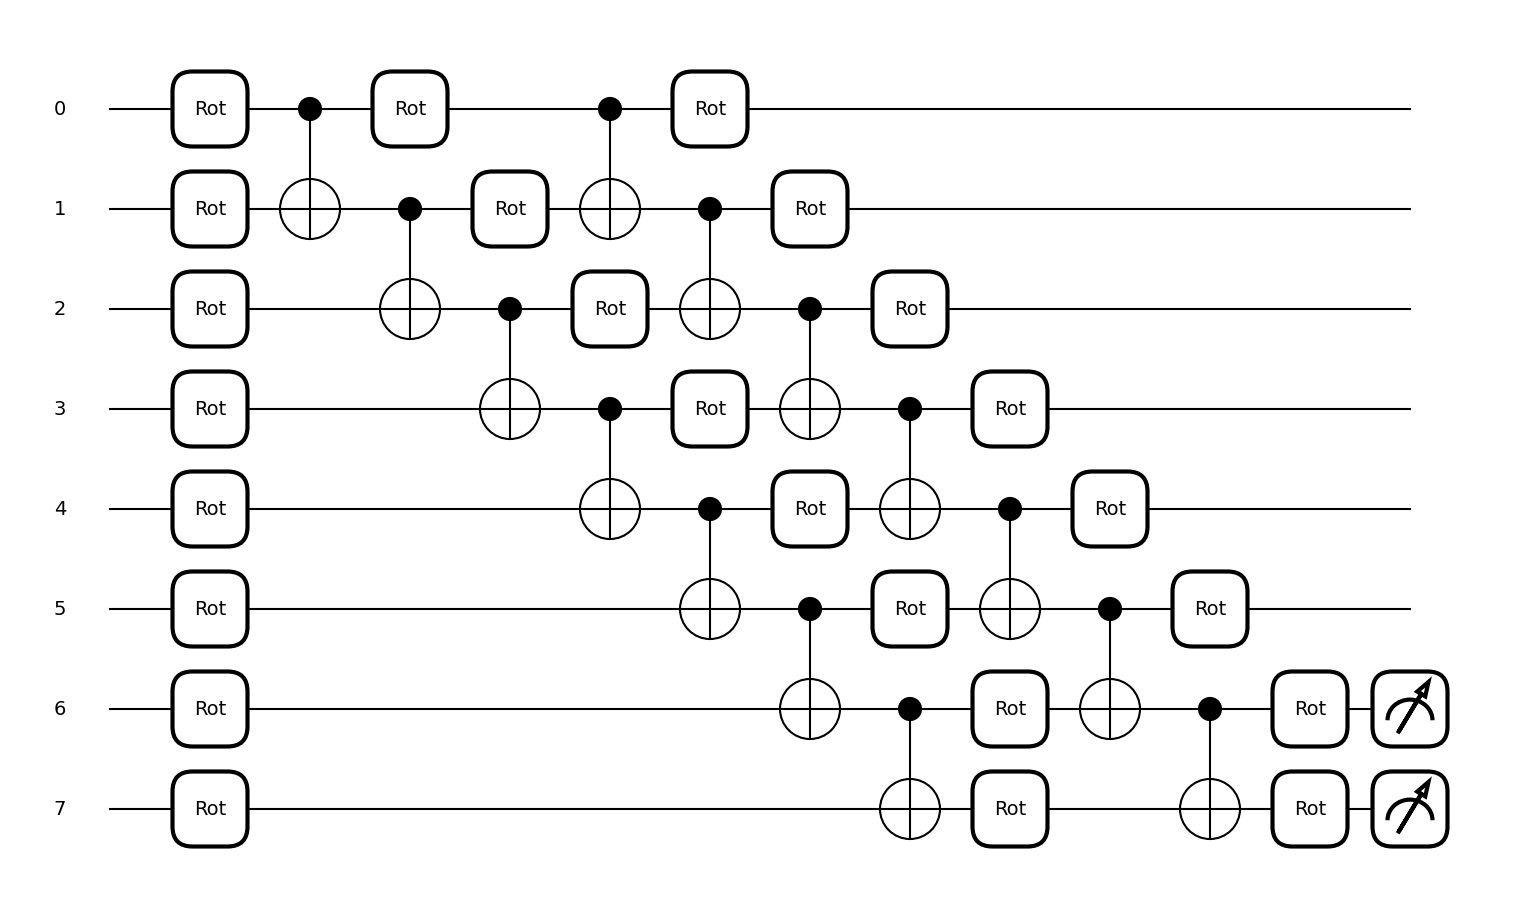

In [10]:
# Visualize the trained quantum circuit

@qml.qnode(dev, interface='torch')
def Classifier(params):
    wires = [i for i in range(n_qubits)]
    Quantum_classifier(params)
    return qml.probs(wires=[6,7])


qml.draw_mpl(Classifier)(model_qnn.params)

## 7. Analysis of QNN Results

Now let's examine the performance of the trained quantum neural network. We will focus on the differences compared to the overfitting problems the classical neural network (Classical NN) experienced earlier.

### 📊 Key Points to Observe
1.  **Remarkable Generalization Performance:**
    *   The classical model likely could not properly draw the entire phase diagram with only 20 training data points.
    *   In contrast, the QNN can **almost perfectly reconstruct the complex phase boundaries of the Test Set (800 samples)** with the same 20 data points.

2.  **Decision Boundary:**
    *   Looking at the decision boundary graph below, you can see that the boundary lines created by the QNN are very similar to the actual physical phase transition points ($J_2 = \pm J_1 - 1$, etc.).

Running inference...
Quantum neural network result


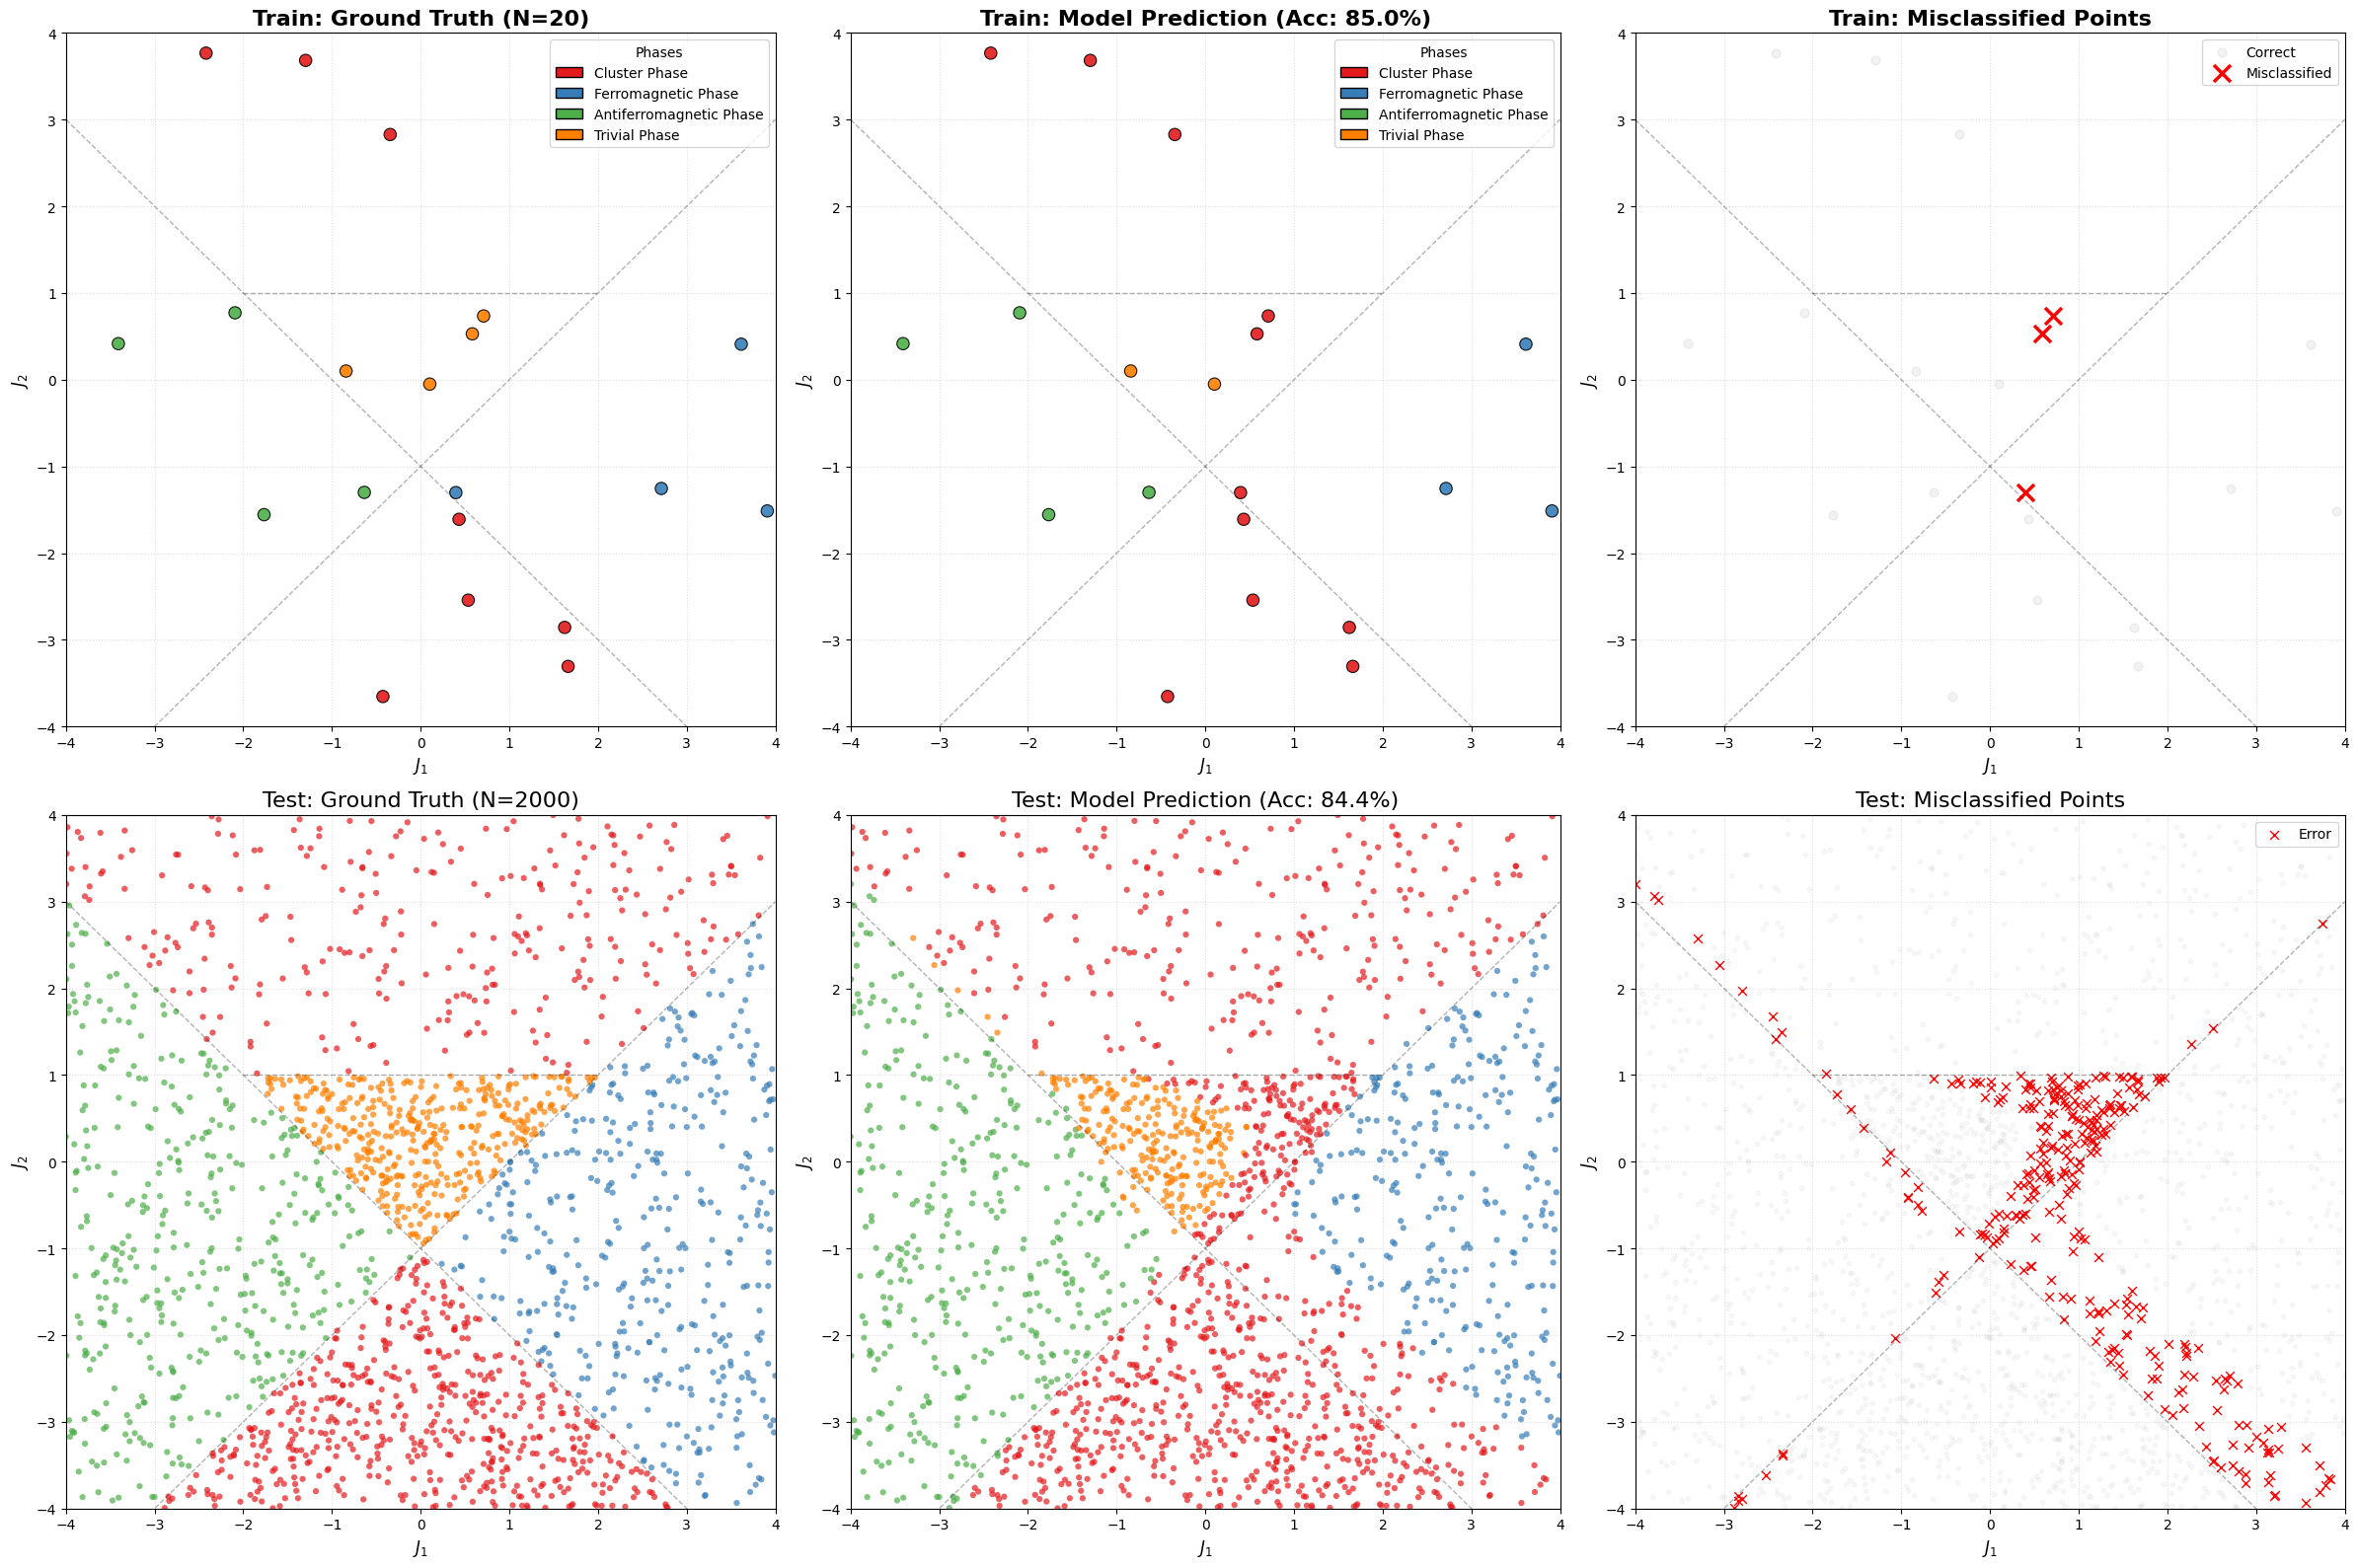

Classical neural network result


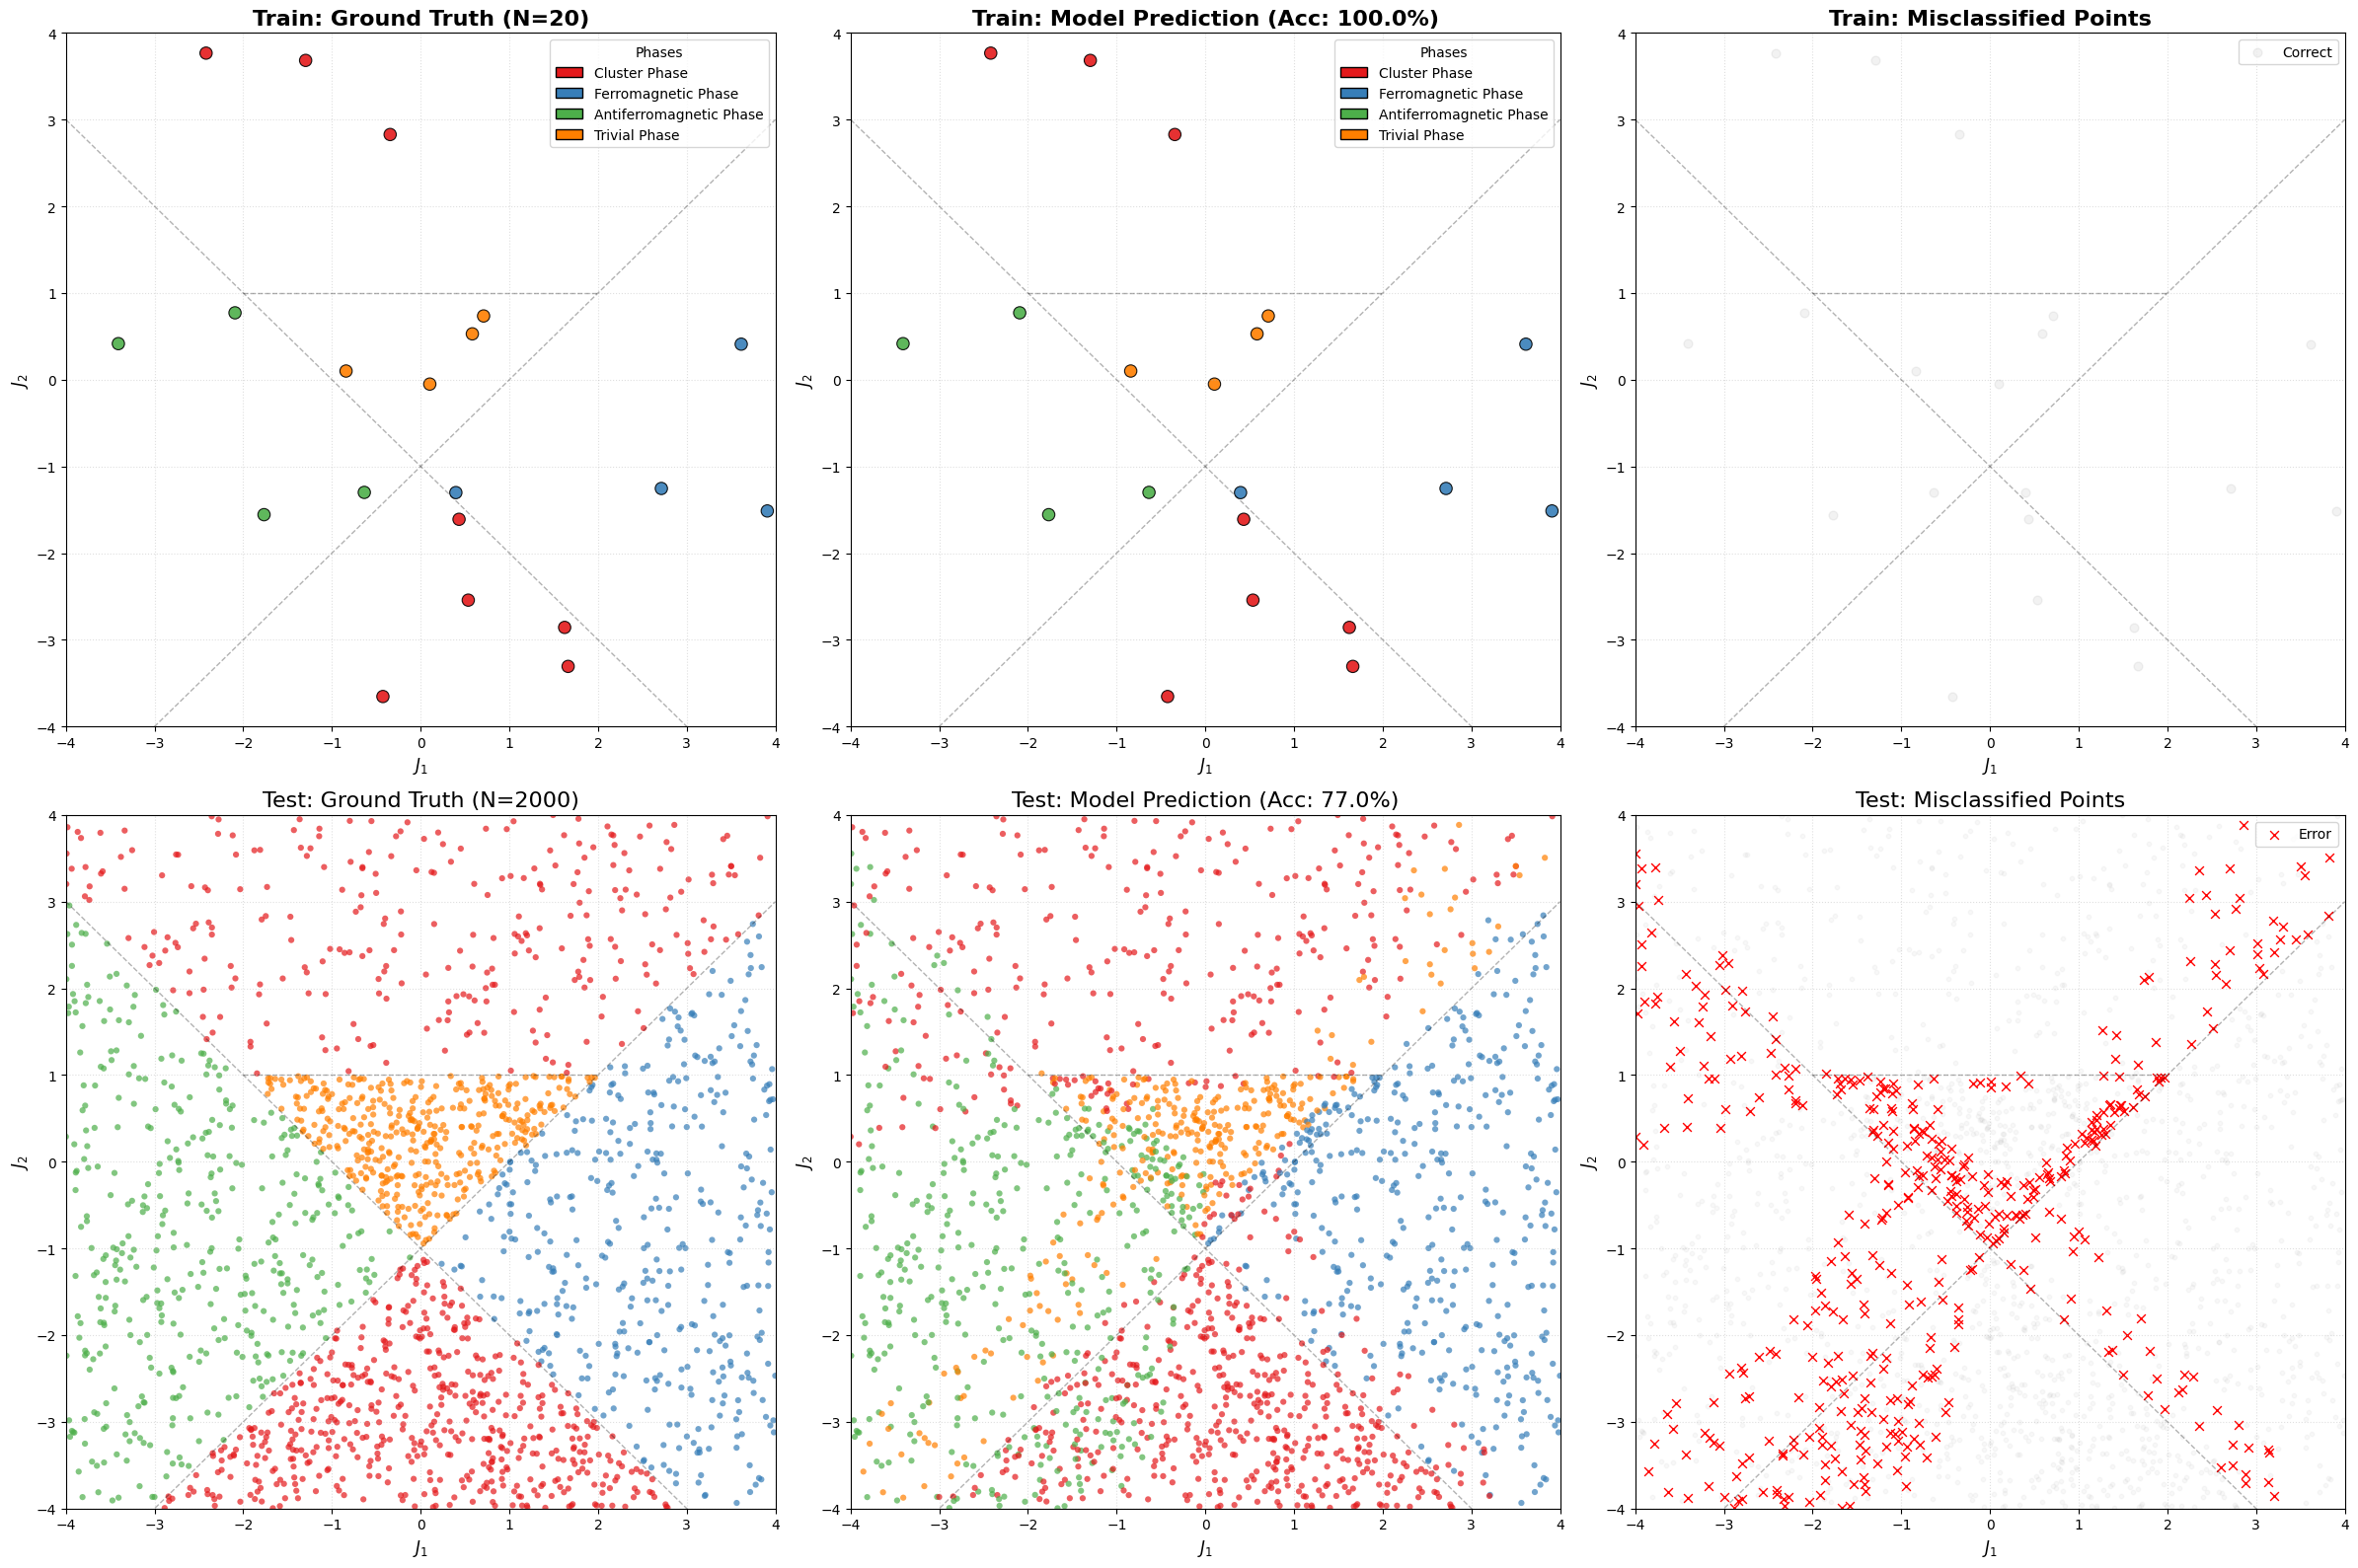

(np.float64(1.0), np.float64(0.77))

In [11]:
print("Running inference...")
# Train Set Prediction
pred_train_y = get_predictions(model_qnn, t_train_X.to(device=device, dtype=torch.float32))
true_train_y = t_train_y.numpy()

# Test Set Prediction
pred_test_y = get_predictions(model_qnn, t_test_X.to(device=device, dtype=torch.float32))
true_test_y = t_test_y.numpy()


## classical vs quantum comparison
pred_train_y_classical = get_predictions(model, t_train_X.to(device=device, dtype=torch.float32))
pred_test_y_classical = get_predictions(model, t_test_X.to(device=device, dtype=torch.float32))


print("Quantum neural network result")
plot_full_comparison(train_params, true_train_y, pred_train_y, test_params, true_test_y, pred_test_y)
print("Classical neural network result")
plot_full_comparison(train_params, true_train_y, pred_train_y_classical, test_params, true_test_y, pred_test_y_classical)

Plotting decision boundary for QNN...


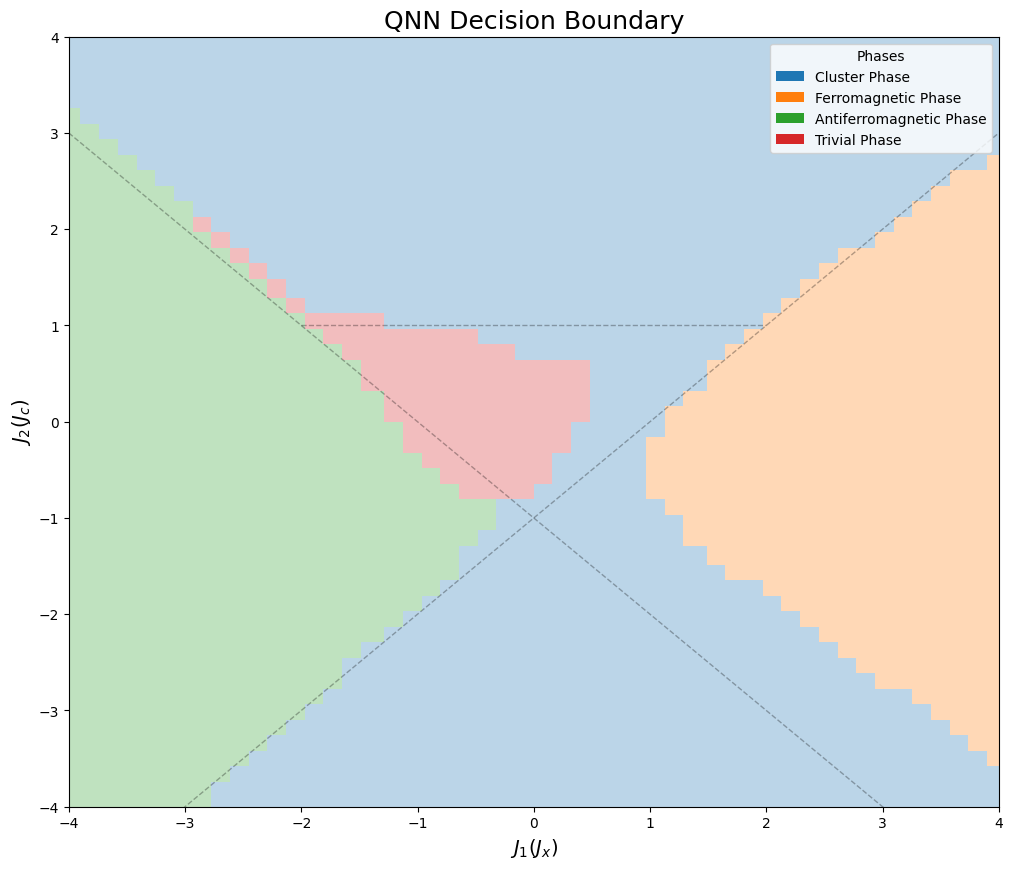

Plotting decision boundary for Classical NN...


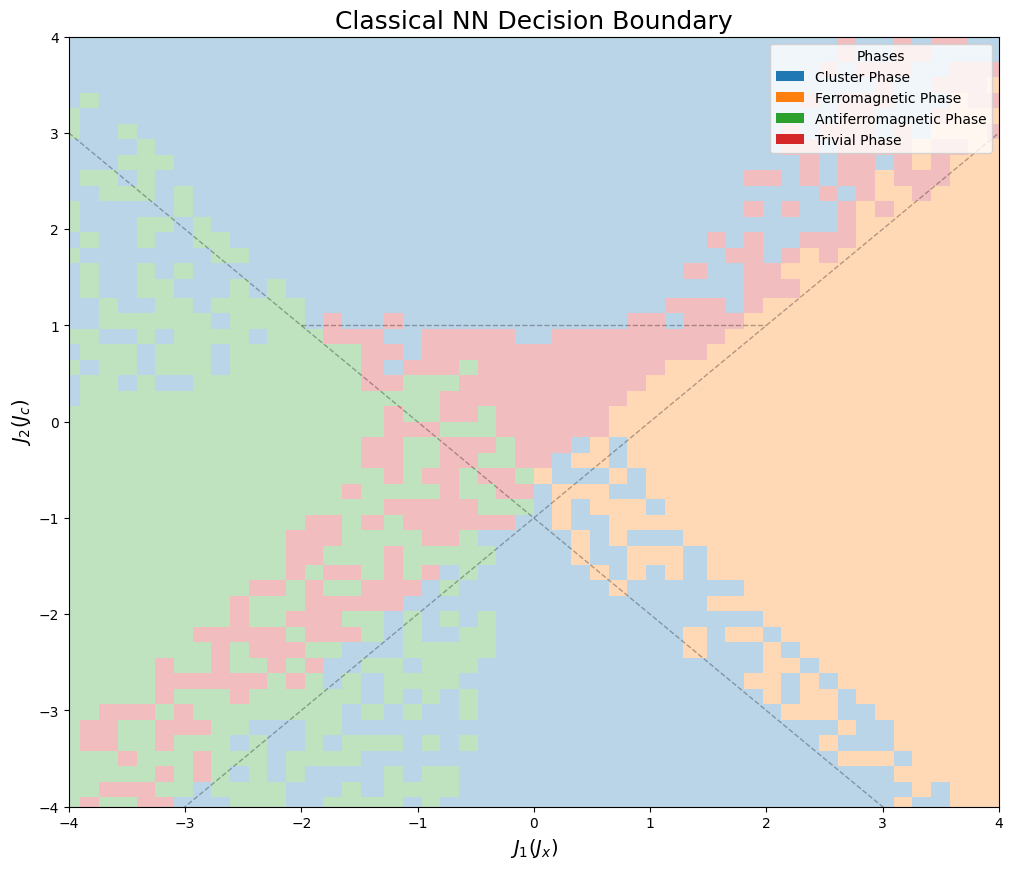

In [12]:
train_y_np = grid_Y.numpy() if torch.is_tensor(grid_Y) else grid_Y

for model_name, model_instance in [ ('QNN', model_qnn),('Classical NN', model)]:
    print(f"Plotting decision boundary for {model_name}...")
    plot_fast_decision_boundary(model_instance, torch.tensor(grid_X).to(device=device, dtype=torch.float32), grid_params, title = f'{model_name} Decision Boundary')

## 8. Submission

Participants must submit the following two items:

1.  **OpenQASM String:** A string converted from the trained quantum circuit (Classifier) to OpenQASM format
2.  **Measurement Qubits:** A list of qubit indices to measure for classification (e.g., `[6, 7]`). Make sure to maintain the correct index order.

### 📝 Submission Guide
1.  **QASM Conversion:** Convert the quantum circuit with trained parameters applied to a string using the `qml.to_openqasm` function.
2.  **Important Notes:**
    *   Do not include the input state preparation (`StatePrep`) part.
    *   Only the **classifier (Ansatz) circuit** part should be converted.
    *   Be careful not to include the measurement part. (The grading system will measure based on the submitted measurement qubit information.)
    *   Make sure to match the index order, e.g., labels=[2, 0] -> [probs[0][2], probs[1][0]]

The submitted QASM code and measurement qubit information will be reloaded in the grading system and evaluated against a **Hidden Test Set**. Run the code below to generate and verify the QASM string for submission.

---

### 🎯 Why Do We Need to Specify Measurement Qubits?

The ultimate goal of quantum phase classification is to **distinguish quantum phases with the minimum number of measurements (shots)**. In real quantum hardware, each measurement is costly in terms of time and resources, so extracting maximum information per shot is crucial.

#### ⚛️ POVM-like Measurement Strategy

When we measure 2 qubits, we get one of 4 possible outcomes: $|00\rangle$, $|01\rangle$, $|10\rangle$, $|11\rangle$. Our goal is to train the quantum circuit such that:

| Measurement Outcome | Probability | Corresponding Phase Label |
|:-------------------:|:-----------:|:-------------------------:|
| $\|00\rangle$ | $P_{00}$ | Label 0 |
| $\|01\rangle$ | $P_{01}$ | Label 1 |
| $\|10\rangle$ | $P_{10}$ | Label 2 |
| $\|11\rangle$ | $P_{11}$ | Label 3 |

This is analogous to designing a **Positive Operator-Valued Measure (POVM)** where each measurement outcome directly corresponds to a phase classification decision.

#### 💡 The Learning Objective

The QNN learns to transform the input quantum state $|\psi\rangle$ such that:
- For states in **Phase 0**: The probability of measuring $|00\rangle$ is maximized
- For states in **Phase 1**: The probability of measuring $|01\rangle$ is maximized
- For states in **Phase 2**: The probability of measuring $|10\rangle$ is maximized
- For states in **Phase 3**: The probability of measuring $|11\rangle$ is maximized

$$
\text{Classification} = \arg\max_{k \in \{0,1,2,3\}} P_k
$$

#### 🚀 Practical Benefits

1. **Minimal Shots Required:** With a well-trained classifier, even a single measurement can provide the correct classification with high probability
2. **Hardware Efficiency:** Only 2 qubits need to be measured, regardless of the system size
3. **Optimal Information Extraction:** The circuit learns to concentrate distinguishing information into the measurement qubits

This is why specifying the correct measurement qubits and their order is essential - it defines how the 4 probability outcomes map to the 4 phase labels!

In [13]:
import json

# 1. Specify measurement qubits
measurements = [6, 7]

# 2. Extract trained parameters
params = model_qnn.params.detach().cpu().numpy()

# 3. Define circuit for QASM conversion (Ansatz only, no StatePrep or Measurement)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    Quantum_classifier(params)

# 4. Generate OpenQASM string
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:10]))


with open("preliminary_data/data_submit.json", "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)
print("✅ Submission file 'data_submit.json' created.")

✅ Measurement Qubits: [6, 7]
✅ QASM Data Generated (Length: 1789 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(-0.776006) q[0];
ry(-0.0033746702) q[0];
rz(0.4004363) q[0];
rz(-1.5740552) q[1];
ry(-0.5628749) q[1];
rz(1.5699067) q[1];
✅ Submission file 'data_submit.json' created.


---

## ⚠️ Important Submission Requirements

Before submitting your model, please ensure that your code meets the following requirements:

### 📋 Code Structure Requirements

Your submission must clearly demonstrate the following **three-step process**:

1. **Data Loading & Preprocessing**
   - Load the provided training data
   - Any preprocessing steps must be clearly documented

2. **Model Training**
   - Your model must start with **random initial parameters**
   - Training process should be fully reproducible

3. **Testing & Evaluation**
   - Demonstrate model performance on test data
   - Generate the submission file (`data_submit.json`)

### 🔐 Reproducibility Requirements

To ensure fair evaluation, your code must be **verifiable by the organizers**:

| Requirement | Description |
|-------------|-------------|
| **Random Initialization** | Model parameters must be initialized randomly (not pre-trained or hardcoded) |
| **Seed Independence** | Your code should work correctly with **different random seeds** |
| **No Hidden States** | Do not load pre-trained weights from external files |
| **Clear Training Loop** | The complete training process must be visible in your notebook |
| **Package Versions** | Clearly specify all package versions used in your code |

### 📦 Package Version Requirements

Please include the versions of all major packages used in your submission. You can obtain version information using:

```python
import pennylane as qml
import torch
import numpy as np

print(f"PennyLane: {qml.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
```

**Recommended versions for this hackathon:**
| Package | Recommended Version |
|---------|---------------------|
| PennyLane | >= 0.42.3 |
| PyTorch | >= 2.9.1 |
| NumPy | >= 2.2.6 |
| SciPy | >= 1.15.3 |

> ⚠️ **Note:** Different package versions may produce slightly different results due to numerical precision differences. If you use non-standard versions, please document them clearly in your submission.

### ❌ What NOT to Do

- ❌ Submit pre-trained models without showing training code
- ❌ Hardcode optimized parameters directly
- ❌ Use external pre-computed weights
- ❌ Hide the training process
- ❌ Use undocumented package versions

### ✅ What TO Do

- ✅ Show complete data → training → testing pipeline
- ✅ Use `torch.manual_seed()` or `np.random.seed()` for reproducibility (but results should work across different seeds)
- ✅ Initialize model parameters with random values (e.g., `torch.randn(...)`)
- ✅ Document any hyperparameter choices
- ✅ Include a cell that prints all package versions at the beginning of your notebook

### 🔍 Verification Process

The organizers will:
1. Run your notebook from scratch with a **different random seed**
2. Verify that training produces a working model
3. Evaluate your submitted QASM on a **hidden test set**
4. Check that your code runs with the specified package versions

**Make sure your code is clean, well-documented, and fully reproducible!**

In [14]:
!pip install pennylane-qiskit

--- Verifying Submission ---
Running inference on Test Set...


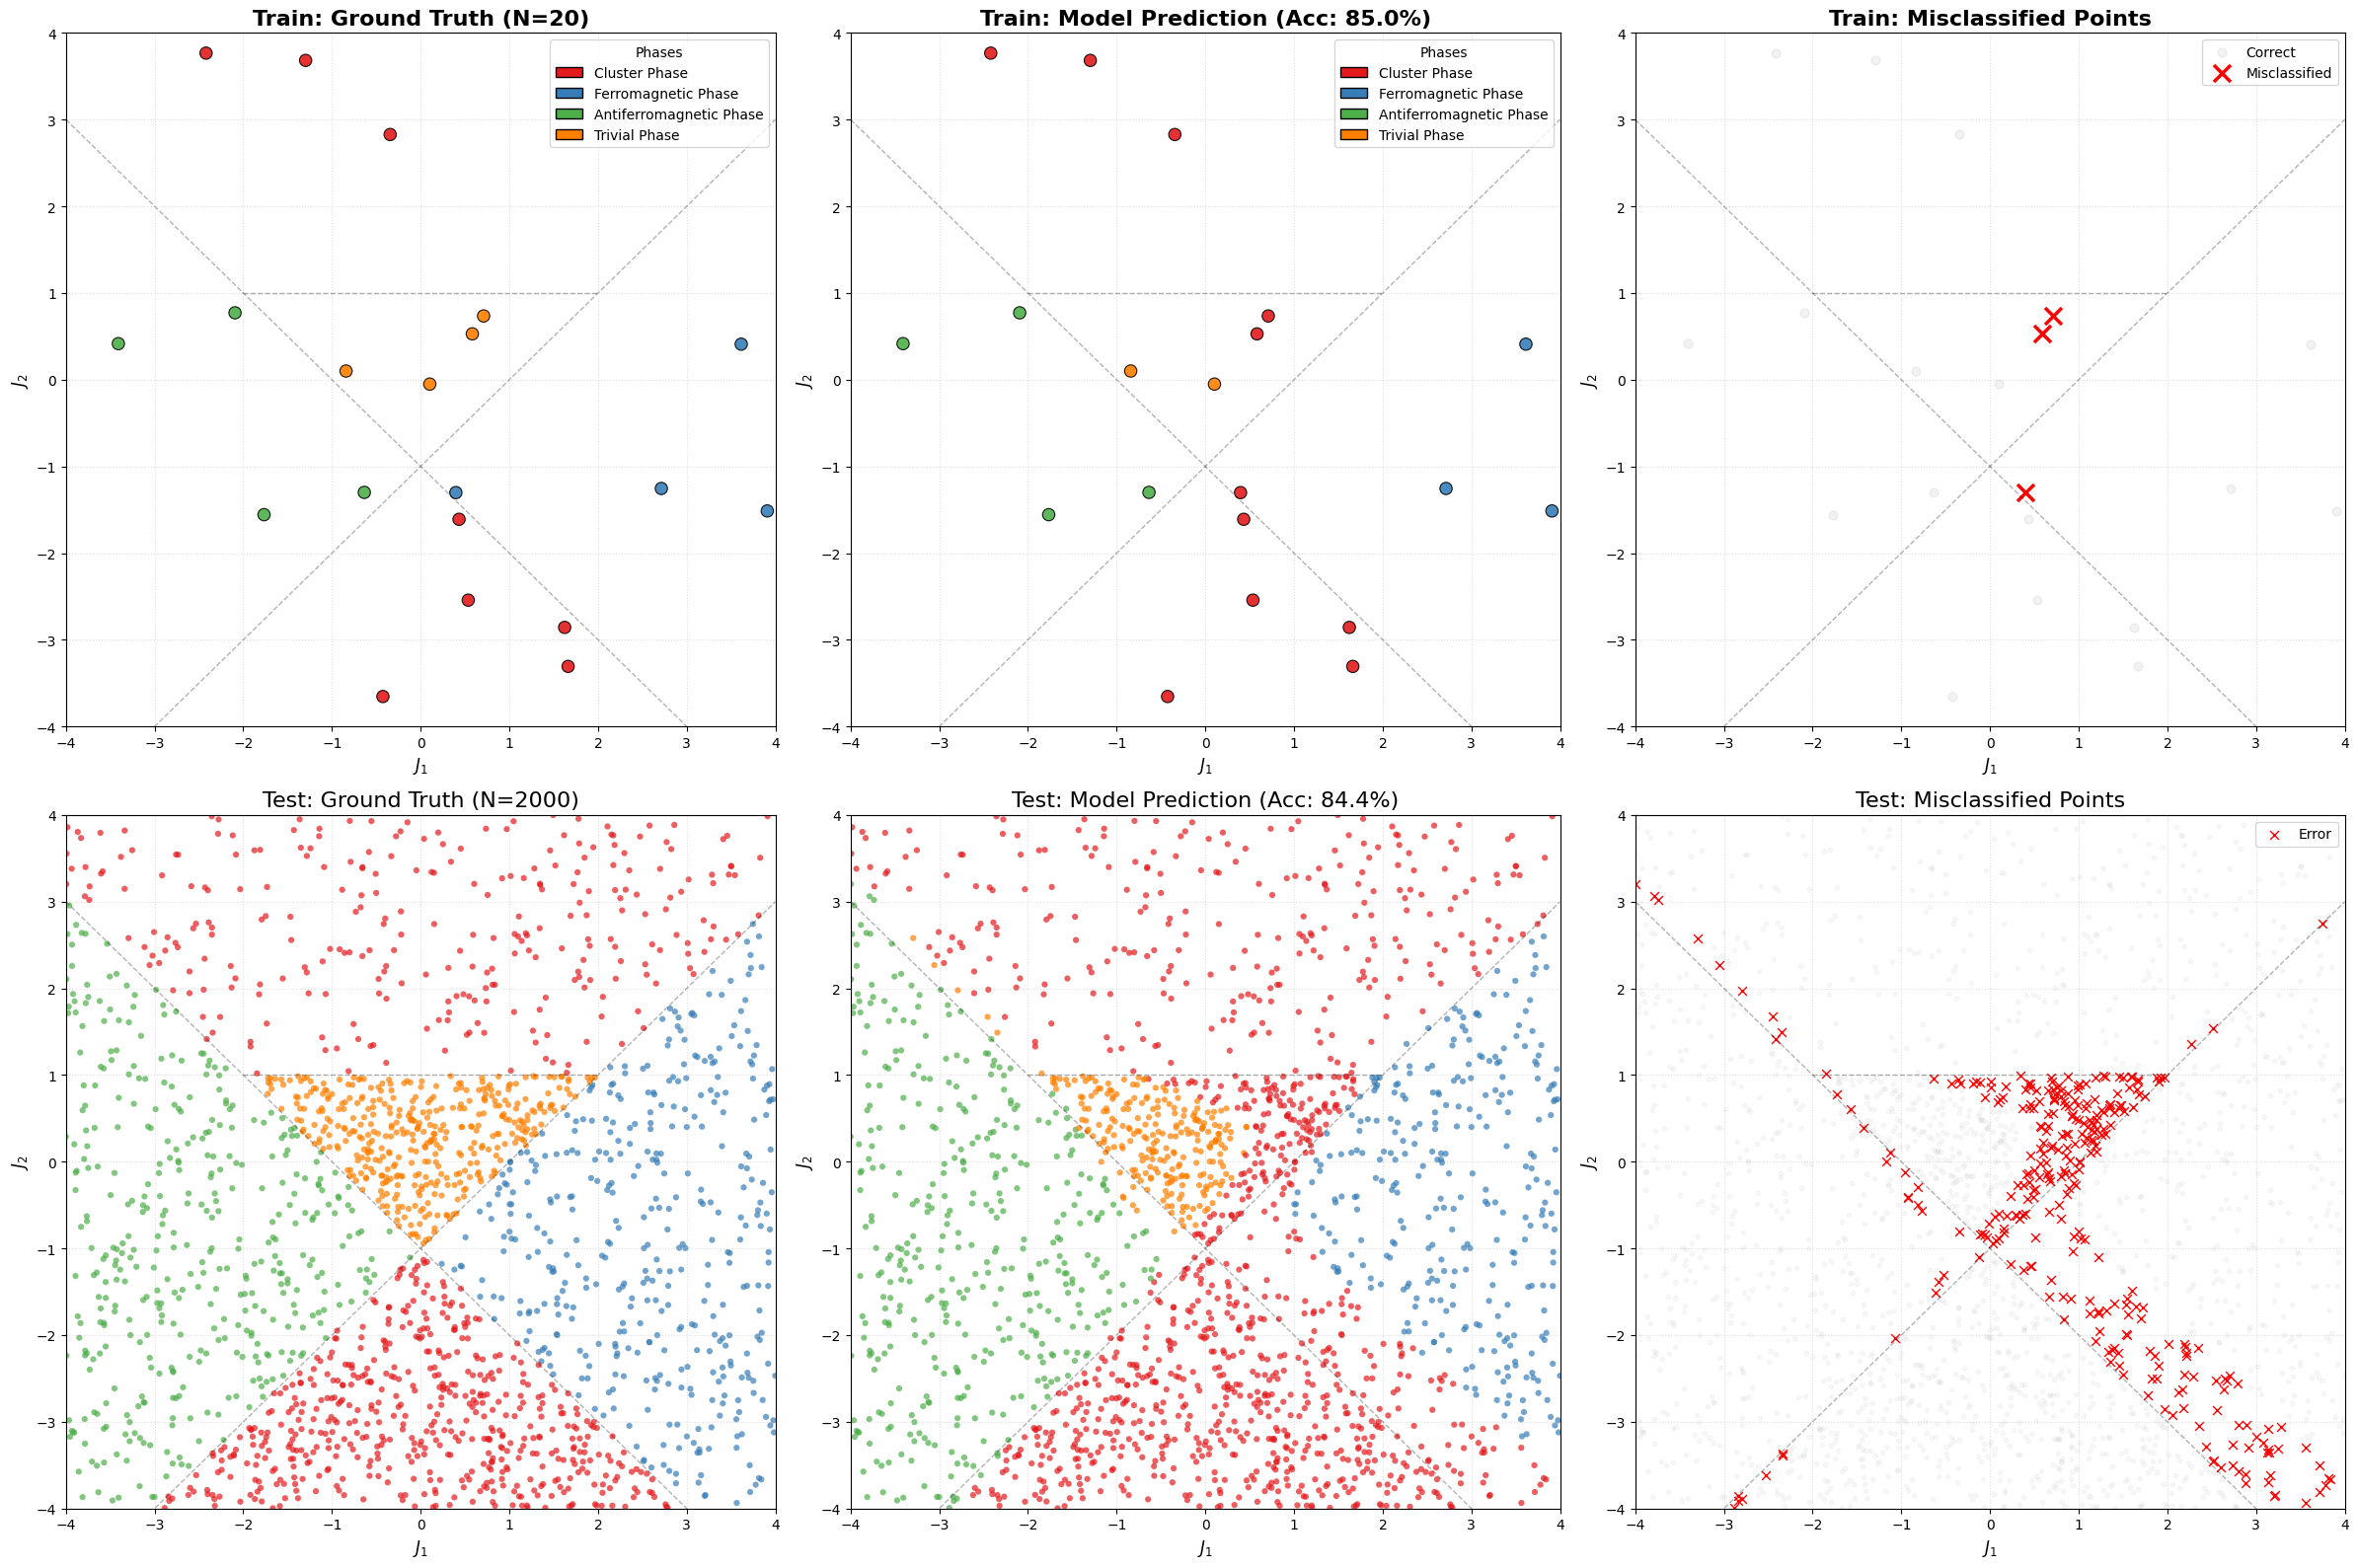

✅ Verification Completed!


In [15]:
def verify_submission(data):
    """
    Verify the submitted QASM string and measurement qubit information.
    """
    measurement_qubits = data['measurements']
    qasm_str = data['qasm']
    print("--- Verifying Submission ---")
    if len(measurement_qubits) != 2:
        raise ValueError("Measurement qubits should be a list of two qubit indices.")

    # 1. Reconstruct circuit from QASM
    @qml.qnode(dev, interface='torch')
    def qasm_qnode(state):
        qml.StatePrep(state, wires=range(n_qubits))
        qml.from_qasm(qasm_str, measurements=[])(wires=range(n_qubits))
        return qml.probs(wires=measurement_qubits)

    # 2. Define verification model
    class VerificationModel(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, x):
            return qasm_qnode(x)

    verification_model = VerificationModel()
    verification_model.to(device)

    print("Running inference on Test Set...")
    # 3. Evaluate performance
    pred_train_y = get_predictions(verification_model, t_train_X.to(device=device, dtype=torch.float32))
    true_train_y = t_train_y.numpy()

    pred_test_y = get_predictions(verification_model, t_test_X.to(device=device, dtype=torch.float32))
    true_test_y = t_test_y.numpy()

    # 4. Visualize results
    plot_full_comparison(train_params, true_train_y, pred_train_y,
                         test_params, true_test_y, pred_test_y)

    print("✅ Verification Completed!")

# Run verification
with open("preliminary_data/data_submit.json", "r") as f:
    data_submit = json.load(f)

verify_submission(data_submit)

## 9. Hackathon Task

### 🎯 Problem Description

You will be given ground states from an **unknown Hamiltonian** and must classify them into **4 distinct quantum phases**. The exact physics of the Hamiltonian is hidden - your model must learn to distinguish phases purely from the quantum state data.

### 📊 Evaluation Details

| Item | Description |
|------|-------------|
| **Train Set** | **16 samples** (provided to participants) |
| **Test Set** | **2,000 samples** (hidden, used for evaluation) |
| **Task** | 4-class phase classification |
| **Metric** | Classification accuracy on hidden test set |

### 🏆 Ranking & Advancement

1. **Accuracy Leaderboard:** Rankings will be determined by test set accuracy
2. **Tie-Breaker:** If multiple teams achieve the same accuracy, the team with **fewer CNOT gates** in their circuit will be ranked higher
3. **Finals Qualification:** **Top 10 teams** on the leaderboard will advance to the finals

### 📈 Leaderboard Display

The leaderboard will show the following information:

| Condition | Displayed Information |
|-----------|----------------------|
| **Normal** | Only **Accuracy (%)** is displayed |
| **Tie-breaker needed** | If multiple teams have the same accuracy, **CNOT gate count** will also be displayed |

> 💡 **Tip:** Even if you achieve high accuracy, optimizing your circuit to use fewer CNOT gates can give you an advantage in case of ties!

### 🔍 Code Verification Process

> ⚠️ **Important:** Top-ranking teams will undergo a **code verification process** before finals qualification is confirmed.

The organizers will:
1. Review your submitted notebook for compliance with all requirements
2. Re-run your code from scratch to verify reproducibility
3. Check that parameters are randomly initialized (not pre-trained)
4. Verify that no external pre-computed weights are used
5. Confirm that package versions are properly documented

**To pass verification, ensure your code is:**
- ✅ Clean and well-organized
- ✅ Fully executable from top to bottom
- ✅ Clearly documented with comments
- ✅ Compliant with all submission requirements (see Section 8)

Teams that fail code verification may be disqualified from finals advancement.

### 🔧 Gate Counting Rules

> **Important:** If your circuit contains **2-qubit gates other than CNOT** (e.g., CZ, SWAP, CRX, etc.), they will be **decomposed into CNOT gates** using the simplest decomposition method for counting purposes.
>
> For example:
> - `CZ` → 1 CNOT (+ single-qubit gates)
> - `SWAP` → 3 CNOTs
> - `CRX`, `CRY`, `CRZ` → 2 CNOTs (+ single-qubit gates)

### 💡 Tips for Success

*   **Modify Ansatz Structure:** Try different structures besides the `Linear 2-Qubit Block` shown in the tutorial
*   **Hyperparameter Tuning:** Adjust learning rate, number of layers, optimizer, etc.
*   **Circuit Efficiency:** Minimize CNOT gates while maintaining accuracy (important for tie-breaking!)
*   **New Ideas:** Improve performance through data preprocessing or loss function improvements

### ⚠️ Important Reminders

- Your code must be **reproducible** (see Submission Requirements section)
- The test set is **completely hidden** - do not overfit to the provided data
- Focus on **generalization** with minimal training data
- **Write clean, verifiable code** - top teams will be reviewed!

Create the best quantum classifier with your creative ideas! Good luck! 🚀

---

## 10. Understanding Your Results: Phase Diagram Analysis

When you submit your model, you will receive a visualization like the one below that helps you understand your model's performance.


<img src="./image/sample_3.png" alt="tutorial" width="800">


### 📊 How to Read This Diagram

**Your Task:** Classify ground states of an **unknown Hamiltonian** into **4 distinct phases**. The exact physics of this Hamiltonian is hidden - your model must learn to distinguish phases purely from the quantum state data.

### 🔍 What the Visualization Shows

Each subplot displays results for one of the 4 phase labels. The X-axis represents the **normalized distance from the phase boundary** (0~1), calculated independently for each label to ensure fair comparison across phases with different boundary ranges.

- **Top Row (By Prediction):** Points grouped by what your model predicted
  - X-axis range: **-1 to 1**
  - Blue dots = Correct predictions (positive distance: 0 to 1)
  - Red X marks = Errors (negative distance: -1 to 0, indicating wrong predictions placed outside the true boundary)
  - The vertical dashed line at x=0 separates correct (right) from incorrect (left) predictions

- **Bottom Row (By Ground Truth):** Points grouped by their true labels
  - X-axis range: **0 to 1**
  - Green dots = Correctly classified samples
  - Other dots = Misclassified samples (errors occurring within the phase region)

### 📋 Detailed Error Analysis & Confusion Matrix

Along with the visualization, you will also receive a detailed text report:

```
============================================================
                    RESULTS SUMMARY
============================================================
  Train Accuracy: 100.00%
  Test Accuracy:  82.50%
============================================================

=== Error Summary by Label ===
Label 0:  503 samples,   0 errors, Acc: 100.0%
Label 1:  503 samples, 128 errors, Acc: 74.6%
Label 2:  503 samples,  27 errors, Acc: 94.6%
Label 3:  503 samples, 195 errors, Acc: 61.2%

============================================================
              DETAILED ERROR ANALYSIS
============================================================
True Label      Total  Correct   Errors   Accuracy
------------------------------------------------------------
Label 0           500      500        0     100.0%
Label 1           500      372      128      74.4%
Label 2           500      473       27      94.6%
Label 3           500      305      195      61.0%
------------------------------------------------------------

📊 Confusion Matrix (rows=True, cols=Predicted):
                Pred 0    Pred 1    Pred 2    Pred 3
      True 0       500         0         0         0
      True 1         0       372         0       128
      True 2        10         0       473        17
      True 3         0       195         0       305
```

The **Confusion Matrix** shows exactly which labels are being confused with each other. For example, in the output above:
- Label 1 samples are frequently misclassified as Label 3 (128 errors)
- Label 3 samples are frequently misclassified as Label 1 (195 errors)

This indicates that your model has difficulty distinguishing between these two phases.

### 💡 Using This for Model Improvement

1. **Identify Weak Phases:** If one label has many red X marks, your model struggles with that phase.
2. **Boundary Behavior:** Errors near distance = 0 indicate difficulty at phase boundaries (expected). Errors far from boundaries suggest more fundamental issues.
3. **Per-Label Normalization:** Each phase's distance is normalized independently, so you can fairly compare error patterns across phases with different spatial extents.
4. **Confusion Patterns:** Use the confusion matrix to identify which phases are being confused with each other, then focus your model improvements on distinguishing those specific phases.

Use this feedback to refine your ansatz structure, adjust hyperparameters, or modify your training strategy!